# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
#Install any packages that you might need
# # For instance, you will need the smdebug package
!pip install smdebug
!pip install kaggle
!pip install torchvision

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
  Using cached kaggle-1.5.12-py3-none-any.whl

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
  Using cached torchvision-0.13.0-cp37-cp37m-manylinux1_x86_64.whl (19.1 MB)
  Using cached torch-1.12.0-cp37-cp37m-manylinux1_x86_64.whl (776.3 MB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


In [78]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import IPython
import sagemaker
import boto3
import os
import random
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import PIL.Image
from mpl_toolkits.axes_grid1 import host_subplot

from torchvision import transforms,datasets
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    rule_configs,
    ProfilerRule
)


In [23]:
import PIL.Image
from IPython.display import Image

## Dataset

The dataset contains files already grupped into train and test folders. In the training folder, the images are disposed inside folders for each class.

In [37]:
#Function to upload data and send to S3

def data_upload():
    bucket = 'driver-behavior-scanner'
    #Download data from kaggle API
    !mkdir dataset
    !kaggle datasets download mikoaro/distracteddriver -p ./dataset --unzip
    #Send data to s3
    os.environ["DEFAULT_S3_BUCKET"] = bucket
    !aws s3 sync ./dataset s3://${DEFAULT_S3_BUCKET}/dataset/

In [ ]:
#Function execution

data_upload()

mkdir: cannot create directory ‘dataset’: File exists
100%|██████████████████████████████████████▉| 4.00G/4.01G [00:30<00:00, 101MB/s]
100%|██████████████████████████████████████| 4.01G/4.01G [00:48<00:00, 89.4MB/s]


The classes used for training and their description :
obs. I have deleted the train folder due to issue with sagemaker studio (it was too slow)

In [8]:
path_train = r"./dataset/distracted-driver-detection/test"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [4]:
#Classes description

class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}


Plotting classes distribution for training

Total number of training data : 22424


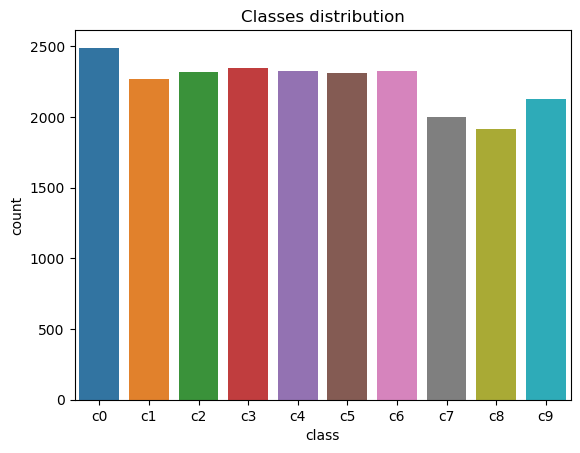

In [15]:
#Classes distribution
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))
plt.show()

Make a preview of the transformation that will be done in the preprocessing phase just to ilustrate some samples of images 

torch.Size([3, 400, 400])
Label: c2 (talking on the phone - right)


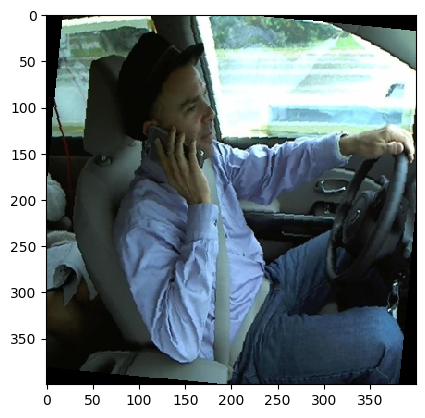

In [31]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor()])
data = datasets.ImageFolder(root = path_train,transform = transform)

img,c = data[5000]
print(img.shape)
print("Label:", classes[c], f"({class_dict[c]})")
plt.imshow(img.permute(1,2,0))
plt.show()

## Hyperparameter Tuning
This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64]),
    "epoch" :  IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
inputs = 's3://driver-behavior-scanner/dataset/distracted-driver-detection/train/'
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://driver-behavior-scanner/dataset/distracted-driver-detection/train/


In [9]:
#TODO: Create estimators for your HPs

estimator_hp = PyTorch(
    entry_point="./code/hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p2.xlarge"
)

tuner = HyperparameterTuner(
    estimator_hp,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type
)

In [11]:
# TODO: Fit your HP Tuner
tuner.fit({'training':inputs}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
hyperparameters = best_estimator.hyperparameters()

print('Best estimator was : {}'.format(best_estimator))
print('-- Hyperparameters : {}'.format(hyperparameters))


2022-07-17 02:35:03 Starting - Preparing the instances for training
2022-07-17 02:35:03 Downloading - Downloading input data
2022-07-17 02:35:03 Training - Training image download completed. Training in progress.
2022-07-17 02:35:03 Uploading - Uploading generated training model
2022-07-17 02:35:03 Completed - Training job completed
Best estimator was : <sagemaker.pytorch.estimator.PyTorch object at 0x7f70627f1ed0>
-- Hyperparameters : {'_tuning_objective_metric': '"average test loss"', 'batch-size': '"32"', 'epoch': '2', 'lr': '0.040047360372621854', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2022-07-17-00-19-36-208"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-820235860091/pytorch-training-2022-07-17-00-19-36-208/source/sourcedir.tar.gz"'}


In [7]:
hyperparameters = {"epochs": "2",
                   "batch-size": "32",
                   "test-batch-size": "100",
                   "lr": "0.040047360372621854"}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [ ]:
#Create and fit an estimator
outputs = 's3://driver-behavior-scanner/model/'
estimator = PyTorch(
    entry_point="./code/train_model.py",
    base_job_name="smdebugger-driver-behavior-scanner-pytorch",
    role=role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    output_path= outputs,
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

estimator.fit({'training':inputs})

2022-07-20 14:56:43 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-07-20 14:57:40 Starting - Preparing the instances for training......
2022-07-20 14:58:43 Downloading - Downloading input data.....................
2022-07-20 15:02:14 Training - Downloading the training image..................
2022-07-20 15:05:15 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-20 15:05:08,774 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-20 15:05:08,807 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-20 15:05:08,818 sagemaker_pytorch_container.training INFO     Invoking 

In [20]:
#Preparing for debugging
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
##from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
#from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[2022-07-20 16:25:50.755 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://driver-behavior-scanner/model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/debug-output
[2022-07-20 16:25:51.284 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-07-20 16:25:52.303 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


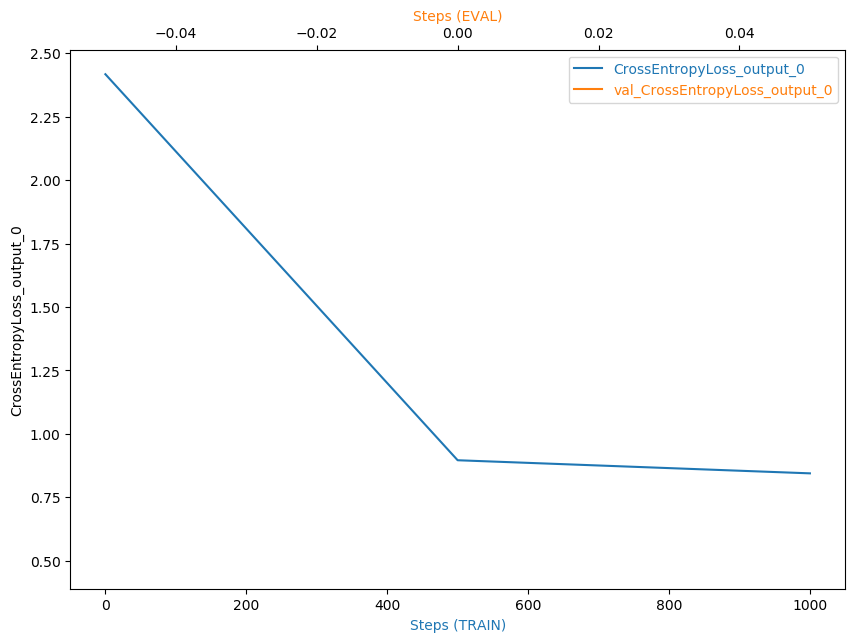

In [23]:
#Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [25]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.1.relu_input_2', 'layer3.2.relu_input_0', 'layer3.2.relu_input_1', 'layer3.2.relu_input_2', 'layer3.3.relu_input_0', 'layer3.3.relu_input_1', 'layer3.3.relu_input_2', 'layer3.4.relu_input_0', 'layer3.4.relu_input_1', 'layer3.4.relu_input_2', 'layer3.5.relu

In [28]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://driver-behavior-scanner/model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/rule-output
2022-07-20 15:27:43     415395 model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-20 15:27:43     270034 model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-20 15:27:38        192 model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-20 15:27:38      39082 model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-20 15:27:38       1910 model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/rule-output/ProfilerReport/profiler-output/profiler-reports/Data

## Model Deploying

In [121]:
#First check if the inference will work in a test environment that simulates the actual process to be done in the API

!python code/test_inference.py --d '{"inputs": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDyYDIHFNaSND8zgdsZ5qGG/gi1ONL+GR7RJMTpDJhmAPODXpOv6/dfDq4hh0/wRpmmfaIt8F1ck3MrDud2cBunHasXoZs4+z0PWb9S9ppN28a9ZHTy0H/AmwKoX8qadJ5UzxvKOqxOGx+NQ614w1/xBKX1PVLiYdk3bUH/AAEYFYscUs7bYo2dvRRmmot7jSZefV5D/q41Ue/NV5L25kHzTN9AcVetfDd9PgyBYFPdzz+VbVr4Xs4Spmd5yOoPC1V0N2W5yKo8rYRWdj2Aya1bLw1qF4oYqsMZ/ic8/lXYpFb2cZ8tIoV74AFQR6nbNdGGCYSEqSF9CPSp5uwuddCDT/DwsoSh1G6wx+dIm2K1W0sLS3OUt1J/vN8x/M1ly69cGR4xCsRU4IPJqjPfT3MgLTuQP4c8UtyNTen1C1tz80qbuyjk1Tl15Qp8mEk9ixrCMMhbcMk0eXJ/FxRyhy9y7Nq15cDHnFB6JxVbe753OzH1Y5pAi5BLH/GnFQBxVbFpJEdNIzn1pxpB0prUe41cA4YdO1aMRW50+4sQqgsBJGcchhWaRhs9fWr9tiJo515ZW/TvQGx0FjdyX+jQuJG3D5GGe4rWtTDaALvDz4G5vT2FY/hqNHutW05Xx/y2hJ9DXV6ZJbCyXNupuEbJbH3qE9DnrWTGpfX00H2eFnRCey810vhu1u9L1KG52kqVxLuPLLVZJhkvtCdssAKtQ3xtWSSaUeXjGc5qXJHPKV9jzv4oeF08O+IVvrKPbpuofOoHSOTuv9a4oHPSvofU7C18Y+HbzQ3P7xk8y2lPZhyMfjXzxLDNZ3M1rcrsngcxyKexFTF20OujPmiKSO1Gajkby495PFUZbt34X5R7d6tGxee6iiPXJ9BVWS/lYnYdgPp1qnkmiqsFiRpXkPzuzH3NNptOoGFOUmm0ozQBOlzLHykjofVWIrd03xv4l0kEWOt3kSnqpfev5NkVzlKKNURKEZbo9S0r45eIbUCPU7a21GIdWx5b/mOP0r1vwt8TvDnihI4Y7oWt6wwba4+Uk/7J6N/P2r5SzSg855BqoPldzCphYv4dD7WYLnlQSO9ZsunvFve0lZWPRSeB9K+btA+JviLRCkct099aKAvk3DkkD0B6ivYvD3xG0jxBEBa3htrvGDZ3BGc/7JPWuqMoyR5FfDVKettDpx9qjSV52yySLtGar6wzQ3GEhZi4++O3tWvCpnjSRwFyMnB4NG+GK8YyEKSPl3d/etNDlTZhWTT2tvJI1pJIsnDZbBxRDOJCqyKioTwW6iujMsTkLuDbhkL60PBC4+aJCPdRUtXLjOzuYqtZ27OsdrGz5+aRz0pgnRJ/MKLs7qp4+tbb6dayf8sFH04qP+xLM87WU+qtU2ZdnJlWOKATuZQmCMqzDmovIRplCxF2J+YEdvrWr9ghUglmbH945p0zRRjnjA6Cna5LTRmXVg6n9xEzpt2jLDinzaSpt4olmIIGMEVPPeJAQAwdj29KllufKiMr4UDjaaLIXMQW+kxQKNw85j1L9BWgAuAGVCB2xWT9r89HLTKgB4B44qD7c6Rr5S7nfgHOSaV0Cm1sdAHRVztG32FHnKxwu0++axla4hRVeYFupU9MfWrdnG+PM81GUj5cDFJ3ubRqN6F1pMAkDOBniq/nLKm92CoT1JqvMLjz22ZUKMlR82ark3tw6LJb4RWyCowc/jRZsUpO5qm7hgRS7qFb7ppr36LJtKPnGenB/GsySzuWlMrNDGD2c7iPyqSXTJXgjSO7cEdBj5KfKVzO1jUt76GdtoPOM0+aTaCUXcw/hFZNlp9zbSjzBnHIdT1PuK1VhLPuJIbGCBRZI0UpP3TOsRP/AGjO80boHHyhu/NSak5RkIb7pBIx0rT2c0FRnpRzaj9mYUUSzWzuLdmk2EBcdzU1jpjxKrXBzJnPXpWwGx2ppNPmYcituYV7aGFtsDEF2LNnpiiSMNcRxM2I1UK23ua051BXoCemaaIVZtzAdBwKtWsYt6mbPp0HmKXKtjouOfzq9bRRR8rGoJ74p7CPADqPqacSmNoGad9LEcxLvA9BR5nvUYjTGMcUoCqMBelRZD5mLvYnjpiky/cgfSnCgqSMUC1ZGxI6DP1o470/Z60hQGquhWGEA07tS7VBzmgMucA0BYgu5TBaTTcZjQtXkjTyDdJODIZCWCE9Sea9T1maNNJuDK4RCAC2PevN7S0N3dzSQTB1i+67DGQfak72NadrFv8AtiaaBUhtx5rkYUewwf5VpvqFy9pFCuFeRgD/AFqguki1g++xkJ6k4xmlRmQqoO4r8oqeZlWRoLazPJGGY7n6Kpya37LSbHTruC4vJ99yzBY1J4DHj8TXMQTSwy7kLK54yO1XDc7NbsFyzu9wgLN7mk9RapnysckbsHBPU11M+v6z4u0uz0i+ukePTlJid1JkI6Yz3xVi7Wwms/s7gbc5AjGMGoLUW1rzawhCRgsTkn8a4b3PcbTKkOj20QzJukbvu4FalrdQWqbAoQDpsWoGkLZz3qIjOeKmzByuW5daWMEpESR/eqhLq17c4Il8sf3UFIbdGB3sBmhYY0HHP1p8pNkU5JHk++7u3+0c0iwyjDINhU8Hpir+Nv3QM+tPZN6jinYZJKYL+2EkzbLqLrt/jqhtCnIFX2tCEDDrTEty3Jp9QRAHOcDj0pVTzVOe1W3hVVz3qOFlUlSOe1NasCIWpK5xQYuM1aDMBtA4NRupA571L3C5QdNpNMHXmp5lAbrnNRgAnmhFEbAqc9jU9u+MgdDUcmMAAUyM7W/GmBpaPdNYeJradslJAYz+NdvaSC3u3Rm285+leeXob7Ok6fejYOK9K0+OPUrSO7tx5gcDcfQ1DlYyr/Dcm3iSVcys+D3rRjHnF4cbkBwGIpIdLkIGVAHcmtGK3jtkyZlXsQWFc7qI4rkOntd6XfRtzsjO4e47iuX+LuhRPJb+LNPj/c3ACXQUfdbsx/lXTz65axAQyTxSEkADv+dcf8QvGBh8Pt4atvLKXTLLMRyUUEELn3IzVwUmzai2pHlc8zTN8xOB0HpUVKTSGulHeFFH86XigYgp3Wm0oNAhe9OApKUcUAHSlFNzSimAtLSCikAucU4MVYMpKsOQR1FMopi9T0bwh8WtX0JorXU2N/py8EN/rEHse/417xous6R4p0+O8066juFUfMD99D6MOxr5DFXLDU77SrkXFhdy20w/ijbGfr61tCrbSRwV8FGbvHRn2GyhACWBK9+9RSXMZJDA4A9Oa8L0X43ala2ywatp8V6y9J0Yo/49j+lej+E/iBY+K3kitJhHcoM/ZpV2sR6j1rdTT2PKq4erDWS0OlbUgBtj3KRx84qM30kp2l2KdDsGCTVgQfacvdQxbh93axyfriiNFDEIscIQYB25NK0mZEMbNv3SCVYwOA3U1LNLamJZJSfn4RMnk+lSxRRRguWaZmP3nPGf6UkluL0JvgMboQVPpimo2CxTnurVH3yW7tJxjHT6VdZoZ7SJLiBsSjOwnofrVldOj2sPL3bvvFjnNTSWaSRhJUVgP0o91GqpT3MdYoriU+XpnzJxmR8AYqOWAWm4RRMZ36lMkKPQV0ENqkaBVAAHapfLC9qnmimarDyauzCisJ5QGKgFgOW6j8K07WxW2j2ruYZyAx6VcVRUmABxSlO5vTw63Zn/AGMeeZgW3ntnipDbs64ZmX3FWc88UhJIpczH7GBHHAsagCn7RQM0uDSuUopLRCHAppJHSn7fWkxnoKLg4sj59acvuaUoR1FG2nchRaYrbR0qCRsjAzUjKKYRTRFRtkBHGKQALwPve5qYoOppPkU5A5q7mDi+pSkdm64C56e9TRKTyelMkkLYAQjnqafExH3uTWj2IJwBQWUUhcUhBJ6VmXe2w/zBTWkHpTQrHqKDGfUCiyC8gLEjioixXvip8KO+aYzxgn5dxqkTbuyEtxkmlQ4z3PpUgkLdIz+VNzJnO3B96dwsYviOGSfRZUPyKxHJ+tc7pqW0UJWIFueTjrXcX9sb3TpoOhZePrXL6dAEj2MuGDkECpepa2K0qzzSeZIQo7D2psMUaFfLw7nuegq/qVt9mlSN/mH3gQazJWAICj5feoZa1Wg1vMF0ybgwzgY6ZrU0+2CX9qk2CyzKVI9azrdWdndeAi9PrVmx3/2rZID8vnqQPSkK2p89hGxzUqBVxkZpY42dsD9auLaIoy0gz6Vx7HtbFcIWBZVphDZ6VdWSKI7Sf0qNpVc7lGMUmK5VELO2NpqX7KQuc/hVpZNwyBQck+1JyFchW3RBluaUqoPA49Key596coyOaXMFxhZtvAGKjjQ5Iz+FOaZEOMbj6CoDLIWyvH0oGrlnyN3DHHuaoSjy5sqcgHrUjNK/BZm+poSHrnvzTQwMpOCKjZmbk81OsB78U8pGnDEUmxmfImVzjpUSDDcjNXpZotpVckj2rPyQxOe9OIIVxzmmEZNSElhTTnpmrKLMcsRsZY3H3l4xWr4V8RXGjweUuPJl4Ib+FvWsFcn5c8U+zXPnRE/dORUNK+o+VSi0z0GTV76dObhlz2XpVR3lkUmSR2weMnNVtMmiutLcM/8ApEZ2tn09a0redLRWACTMRn5u1UklsjlUIogjtGmkIKYwMkkV5nqM5udRuJi2dznB9u1ery3Oqtp9zPHZqkEcTuzgdgprx8nLZpRvfU2p6sSij60VRsHvS0dKKAEoHWl70tMBe1BoHSkpAFLQOKUcmgAHSlHNBOBSA80AFLR1oJoELmgk5oFPVCfrTAWNSxr0n4Q+Gb3WPFtvqqREafYMTNMSQGbBwi+p5BPtWB4H8F3vjTWFs7fdFZREG7uscRr6D1Y9hX1PpOkWOh6VBpumwLDawLtVQOvqT6k9Sa0gupy4iokuVCLYRmXeyg4+6MdKmS0VX7bfQj+tWQop5AArZzZ58aEeoiQrinGMDmm7sU0sanU3vBLYl6Dim5zSK2etP25FLYpPm2E3AUdacIc08Q4pXRahN9CNRT8UoTFLSuWoNIi20bDTyDS4OKLi5CMJTwnFKKUmi41BIRYvWnEAdKFU96cVqbmqjpoiNjgVAzVM3IqPaKuJz1bvYhJz1pTkDipQitQ8ZHSq5kYeydrlUhjyabtI6kVaMRamm075qlJGUqE3siqygn71ACjt0q0LdF6mnfuVp85Kw76tIrKc/dWl2SHtVnzkXtTWuPSlzPsX7OmlrIg8iRjycCnfZV6s1I0hb+KomyTyT+dUuZmTdOPS5P5UQ5bHFG+FBkAVD9abntRy33F7W2yRO04/hWqksrliOAKkyAKjcqTVRSRnOcpbkqmseWGOyvpZHHyyDMfPGe9aoJCDAyabNbx3cBimUHI/I0MF2Oc1CNpUjkzlmycgcVlPBIWwFJb0rW1DTdRs7SP7LmdEZty55xSWUqmNZCGW4l4VWH3feosaJ2RHFaJBGiSH5z97B6VDZrjXrNVBwJsc1fFvIZWON+wZJpbDT5f7ZtpnUDDFjz7UmEdWfO+0AEjqarOzE5J5FXSABzUDBd/TiuKLPZ3K4BNSpDKRkAgHuakDADgYp3njoBmqchofAu0sjEE+1STL5IBYj6VV3MTmh1/ibvUCtqWhNbKpJZ3bsAMCq7SMzEr8o9BURljQcnJ9KryXTHhVxQPlLLhF+YnrVVroA/KM0oO+L94SKiaDLfL0o0HZj/tpU/d+lL9scsOgzTBbnaN1OWEL1o0CwyWaTcQWJzUa7yTyc1a2g9qesbY4BouMqpGQeaif5WI7VoGFgMmqfktNK2BgA8kjrT1GRKRn60/7NNIfkQn3NXoreOIZ28+pqYAn6U7iM8WNwMHcgPsadFZTJfb25jcAEg9K0AuBT1pPUcZNE+lPZ2epRSXRJt2O2UZ7etej28nh/TyGtbXznPO9hx+teYvAky4I56Zra0q/aO2FvN99Put6im5NLRHPVTeqOo8ReIJG8OaoiRJGjW0iDHupH9a8G716rqcrXWl3cKjLPEwGfXFeV4qYNvVl4dNISjtRRVnQL2paSigBaKKKAAUppKUUAFKOBzTe9KKAAnNAoAp4GKAAUm3Jp2Qozmp7e2munVIUyScZPSi4EYUKMkgfWvQPAXwt1TxeyXl55lho2eZiMPMPRAf/AELp9a9A+G/wr0W0trbV9XC6jeyJ5kcbjMMf4dz9a9dA6DoB0A7VdOPNqclWvbSJn6XpNhoWmRadplqltaxDCog6n1J7k+prQQMelShQOtKCq9K2uciptu8mMKSCm7XqbzaRmzyKE2VKEejEWMmhkNHmN0pdrtzS16le61ZCKMVKHAqPynIpNpXqaHZjTlHoWFcGlLioVYdqeMVFjojUbQ8MKAuabmk3kUrFcyW48rim7TSB+aeCTRqgXLIbinrS4paVy1EKQjNLRSKtciKUzZzU56UgWqUjKVNNiKgWmmVKSViBgVWIqlG+5lUq8mkUPe4x0FReYzd6QrQFbsK0SSOKVScnqNYmmHrUvkuacICOTVcyRm6c5PYg5o+tPfaOlR+YG6U1qZSXKw4FGaQ9MmjOKqxFxSajbJyBxUgoCk9qL2CzZEoPOTSnpT/KkI+VD/KniykboApockVGlOWyKxdkxjpTw+SMDmrI0wt96U/gKlTTolOTkn3NQ6sTaODrPoVmVXxnnHSqFzYQ3l0AYyCgzuXg10KwIvQVm654g0rw5afadRuUhU/dXqzn0UdTWftOx0/U2leTsYz6LfWSs2ns0pJJKyMB+FGjW+vPqAl1O3tbeBQeEk3MT+HFcdqnxWu7qQrp9mYoOxcjcf8AD8KxP+EkGpSY1BJC7Hh3csPyqld9TNwjF3SueZI5dgDwKc4+bg8VGqkc4p5HHpXJY9KwmOevFQu2xuOlSOwXGDkVGfmpXKFE7H6UjlmA5pVXjAFSLDI3b86LsRXEXqaXYAOPzq39lwPmcD6UgECcliaLMXMV9uaeqMcYFSGdFPyrTTcu2elKyHccIGJ5OKd5ca/ebNQNKSME1GZMU7oC0ZYkztXJ9SKY1wxGBVXzc9qVWLMBildsCXcW71JGvc01V5xUuMRmmVsGNzVIgwKanTNSKKBMdj0o24pcYpQKZIKMVPFIUIIGT6VDjBp6HmhCZ6LoGi6TqNlFexM8ueHUn7p9CK8Y8Y6M+g+Kb6xZcIJN8ZHdG5Fd7oGry6PeiQOwtpSFmUen96pPivowv9Ntdetf3pgAjmcc5Q/dP4E4q2la6IpyanZnkNFFHakdQoFGKO1JigY6ikHOaKBC5opyxluKsw2odhkHFS3Ydir9aVVZvuqW+grbgsolbG0V1WkaSOJXUADoMdah1LBY42w8P6nqA3RW5RP78nyg1tw+CGjQyX18qgclYhn9TXaBNgAA6VRu4nuZSGOyFRlj61HtGy+VI5uLRrSKTFtbGQngNJyfr7V1mjaTZWiq8sYeTux6Z9qzpzLvhgt49sDn55j39hXQeSkcYjhTagHalJ6ErU73w5rkUZS0JVUBGw/0rug42g9sV4laN5ARu4OcV6h4a1IX1oIXYeYo3L7itsPPocOKotPmidErcZpGbNRAkcUtdlji9pdWJAF7mnjHaoxt707ZnoaTNIvsh+4UGRgOKjIYUmaVivaNEnmOeppufWgYJ5p5jBHFGiBc0hVK08OB0FQlSKQMQeaVi1UcScyZppOaQMpqQAHtS2NU3PqMG0UbsnApxjz0FKkW00roFGV7IkXpS0UVB1JWQUUUUDEPSgdKUjNFBNtSNoxSCFalpNop8zIdON72GNGmOaaoUdBUuBSbRTuDp63SIXlVO2aqPcM5xgitDy19KXy19KpSSMKlCpPS9jNETt/DUyW7D+EVd2gdKWh1GxQwUU7tkBtwwwRUYsUzzVuip52bPD03uiFbaNewqQKo6CnUUm2aRpxjsgxRRRSLsgooJxXGePviBY+DdNKo0c+qzDFva5/8ff0Ufr0FAm0iPx98QrXwhALWBBcatMm6KE/dQf33PYe3U18/6nr13ql/Jf31w1zeSdZG6KPRR/CPas3UtUutSv7m/vp2nvLht0srfxH0HoAOAOwrNeYk4HenczcHJ3Zq/wBpy5P7w1es9aOVSXDIT19K5xQWkVVVnkYhURBlnJ7Ad69X8JfBm/1COO98STvYwHDLZxf6xh/tN/D24FCv0JmoxWp5vukPAzzSiGQnnig3BJ4AFMaVz/FWWgyXyUUfM1OzAvPX2qoX96QyDn1ouMt/aVGNsf40z7Q/rxVXcxbgUojmbACmjVhYlaQk5JqMsM1ItlK5APH1qZbDAyx/KjlYFQvSZZjgCtEWsSH7ufrUm1VGABT5QujOWF3Xoactkx5JxV7PpTWJ7U7JBcgFogxliaHjRCAoxUufeo25k69qHsMAMU4n5SBSUEdakByVOPaoEyKnXkUAxwHanAZ+lJT0pksTHSlUc1IVpoHNIm9yaLniu38LXcF/p1zoN8A8ckZC5/iQ9R9RXDxnBrSsrhrW5iuU+9EQfw7iriZyR554i0Wfw/rlzp0w/wBW3yN/eXsfyrKr1v4uacbnTNL1yLayY8tivOAeRn/PevJD1pHTTlzRuGaKXBoxQaAKkQZNb+ieG/t0fnXTMkZ6BatXfhu0il2QSy8DJyKh1EnYpQbOejTnBq9bED8Kuvo7RorLkjHXFZ7o8M2wggiovcTVjSgOZAc45rv7ba0CFQOgrz2yDSSqBg5PFeg2aFLeJSOQBmplsC3LawiU9OcYqabRBNb+W33W+9inW4GOTWzaODgdaxKMW08O29sVYmRyOgY8CtW40+MQh1XH0NaXlhjgCqHiC5+x6JMw69BQ2COfuZkQnaflHetfwzqk63kfk/fQ5HP5g1zthF/aEDRE4JGc9qs2Ml1Y3aw2cElzNn/ljGzj8SBgVUZcrHNJx1Pb7S5jvbdZ4+AeCD2PcVYxmsHwwl1FaS/bYxFNIQ3lbs7RW8DXp05c0bnh1IqMrIUA54qVUao9+ynLcVTv0Kg4L4mSeWaXy6b9oFOE4NS7m6lTb3E2rmnfdFOwCM00gk8UrlctthMZpQinqacBxSeWAc0rlKPkOEa08ACmgYp3JqWbRsugtFJS0iwooooGFFFFABRRRQIKKr3F9aWi7rm5hhX1kcL/ADqhJ4o0SMZGowy+0GZT+SZoE5RW7NeisUeJbaVM2tpf3J9BbPH+rhRQNYv5QfL0WeI9jcTRqP8Ax1mP6UEutBdTaorES51qTh0sIR6q7yEfhtH86aINVc/vdX+U9ordVP5kmnZkPEQN2o5Jo4kLySKijqWOAKwv7GRyfPv9RmU9Va4Kg/8AfOKItA0mF96afCW9XG4/rmnyMzeKXRFyTxLoiA/8TS1cj+GKQO35Lk1XPiqydT9mtdSuGHZbCVc/iygfrVyOGKL/AFcUaf7qgVIG96fIS8RJmcuualKP3fh28XPQyzQqPxw5P6UC68RSH/j202FT6zO5H4BR/OtLNGRT5ES6sn1M4w6y7bn1aJB3WO1HH4kmh9MeV98upX7H0WXYPyUCr7OqgkkADuaqz6naW0ckksyhI1LORzgCmoozc33MHxXfaL4T0STV72ASyR/LCsjF2kkPQDJr5n1PVbjVtTuNQugouJ2LPsGAvsPpXRfETxlJ4v8AEBeNmXTrUlLaM9z3c+5rkSvG4mok0dVKnbVkbEnmmxozyJHHG0ksh2pGgyWPoKfwFLE8Cvavhh4FXS7ZNe1aAfb5lzbROP8AUIe5H94j8qUVc0qVFCNzT+HHgGDwtbpqmqwLPrcq5AbBFqv91f8Aa9TXoLXcjdSFHtVNpeSahe4HXNdCSR5k5ubuz5cAdugqVLWZ+dpHua0VaNRwB+VOMx7DNciikek5FFdOf+Nuc9BU66fEDkkmpi7fSl5NVZCuxVghQ8KtSlkA6e3SosU4rwOKLi1ELc8CmEknGakCnFMKHPpQAz2JpCRTiPemHFIoaTTWNOpu3NADC3FMHLH1qbYKjYYk/CkykOApccUlOHSpAFHNTIajAz9akUHNAmP7VIg70zbwacnFMROoyKTHWlXmnlc0EEa8EVdtzmqZXBx3qzBwwpoTOpgtF17wne6NJyxU+WcdD1H614bPC9vPJDKpWSNirA9iK9w8O3At9RjyflcbT9a8/wDiP4el0jxDJeIh+yXjb1Ydm7ih7lUZWdjjM06JQ80anozAH86YeKAcc55oZ0nqwSO1aFVA2YG0VLq8SJZsYk/fyKQmO1Yei6tFrFnHCzbL6ADg/wAYHcVvzS/bLRZYULSxoUZB1BrkmmmdKaaMewIm22mcmMDPvVq50O2mIaRPmX04qtBpOrq0c9vDGsoPCvJz+NbBkuVXbeRiOYcOoORmkmRJGfa2FpbFWWJcg8ZrZjkDAe1ZjfLJx0NWYZMAcjNW1cyvqasLc1r2mU+b8awYJQeD3HWt2ydSi5NZu42zdt8MBVLWtNXUbJ7ZjhWFTQyhCPSm6lP/AKPtBIaQ7QRS3EnY4630ORIJoopZNqIQXB7+le3zWkFhbww2sSRQIu1VQYxxxXk8d/a3F5baJBIQ1xOkd1Op4jUkA8+te2XNulxEY2yB7dq2UPdM60XNWMWDCzB/bBq8Dk9aoS6NE0mPPnweT81aMGnxhFG5yVGASeajDYrXlSPP+qzY/aGHNJ5K+tWlgQDpTvKX0rvVRmv1W+5U2xrS+dEtWfJjP8Io8iP+6KmU5vYpYdraxW+1DHSgTu33VJqSaW0sovMuJooE/vSMFH61jzeNPD0E7QjUBPIo5W2iebH4oCKi8urK9nLrI1wJm68VKI2xy5Nc/F4vFzzaaBrU6f3/ACFjH/kR1qd9X1eTDQaRBCn/AE+3gjb8kVx+tHMu5SUFuzbWML6/jTsVz0l3q8mGOo6fa+qJC03/AI8WX+VMlYy4Mur3pcf88Asa/lg/zp8w/awR0tQT3ltagG4uIoQehkcL/OublhtLgL50U07L0aadj+gOKeBCqhVtbdQP9gE/rVJSeyM3iorY2J9b06CNZDciRWOB5CNL/wCgA1Xl8QRiMPbWN9dZPRIhGR/38K1TFwwGA+0egAH8qTzFPViT7mq9nNmTxj6Cf27rks37rRYIoc8faLwB/wAQqsP1p732uzjan9n2nowLzH8sLTfNWgXC1Xsn3MniZsie11a44uddmA9LWBYv1O40xtAtph/pdzf3Y9JrpsfkMCrH2oUfaRniqVJGTqzfUbBoek25zHp9vn1ddx/M1oRxxRDESJH7KoFUftPvS/aM96pQiTzSNDd70u4HvVD7Rx1pPtPv1p2Qrs0Nw9aXdWd9pGOWprX6L1amGpqbqN1Yr6sgOEBY1C2o3UhwuEFIepvs4UZJAHvUEmoW8ecyAkdl5rCYSScySM3sTTkjC9BQPU0n1fJxFCW92OKrve3cv8YjHotRDGOKXcBQAhRn/wBY7Mfc15v8V/FS6daLoNo/7+cBpyP4V7Cu61vWoND0a51GcjbEvyg/xN2FfM+p6jPq+pz31y5aWZyxJ/lUTlZWOjD0+Z3KhkCnimmZ3PJqU2rMu4dKfpej3Gs6xbaZbcSTtgt2Ve5P4Vij0NEjufhh4RXW73+2NQTOm2r/ALtGHE0g/oP517bJc5Oc1j2MFvo+m2+nWi7YLdAicdfU/jQ90e5rojGyPOqyc5F97k44P61UluuOvFUnuD+FVZbkjvTM1E8dC/nUgWmbsik3Gua6PQJsDHWgEDGaizjrTt2Bii4WJNy+lIZcDHtUW/j3pCwzSuFiQSH8Kaz+lMyacAO/SkOw3JNHFKSOwppzQA4fhSE03NGc9aB2FqJuWFOPT2ppHIpDsLjinKMUg4pwpDHLjNTKOc1EBmplAIFMkkxke1KBQBgCnAUWIJIxUmKaowKkC5HFAiMipYh81NK5qSEfMDQhGpCC0ZCnDY4Poa25YIfHHgyS1bH2kDGf7kq9PzrGtuqntT/C+pDSfFTwNua3updjKB0bPymib0IW90ePXVtJaTyQTKUljYo6nsRUFe0fF7wDcWoPieCELbSkJdoOsbdFc+x6H6ivGShDYNTCV0dkXdXLmlgi7VlJUjuOtdxp2piKQPcIxOMebGcH8fWuO06H5w5H0rorcjIzUT1NY3R1WmXEUszyrOXw3Ct6Vp6zarLZy3ZcKQoZR6+1cvDBgh0OG9RTwZ/OzJNI47AngVjyopsjaQnaeg71at3jDdeccZqtLgDp+VQxy/Py2K0RkzaDFSCc89AK17aVkQcZwec9a52G6J+7yFrTgucKG65pSRJ0NveAsEkO0epNSXqveHyonG0Dkg4z9K54TPJN9xjg8Vp+XJLLEkZZWb72O1Z7FrQoyxi0iltwiwxEfO+M4Hqa9y0S9ku9Mi+1PGb2NQlwEPG8dSPY9R7GvEvEESWFxEqM2bmJo5Mnhqh8Aaqmk6zd3uo3zyX93CttDtf7iL3bPU/yrop3sZ1q7b1R9AMiD5mIAHc1C+o2UOA1xHz0wc/yrza81CWSQl7mZ89mfioY7vYQQ5B9jUwpNSuomEsT2R6W+s2SKW83djsFNZsviZw37qzBHbfLtP6A1xX9oZ5ZiR7mnDUgM45roUJvqYSxM+h1Euu6lJJmOW3hT+75Rc/nuH8qoySXczMZdTvWVuqK6ov/AI6AR+dYv9p9s0h1M9d345qlRXVmTrVGaSabp8b7zZRSP6zkykf99E1ejumgTZCViUfwxoFA/KuabUscGQD6mom1KMdZV/OqVKCI5pvqdQ165+/O59i1Rm7jBznJ9c1zI1JG4Us3sFJqZJbqUfurK5Yevlkfzq1GK2QrN7s3jfJ/COaBfZOc1kR22pvwLFl93cCp103VGHK2yfWX/wCtVC5TQ+3e9Kbw92qmukX5HzXttH9FLf4VIuiOP9Zqox/sQ4/maeo+VE/2vA5NH2vPQ00aPZjl726Y+xA/pUi6bpa/eWVyO7Sn+lPUWgz7WMZ3Un22MdZF/OrQtNJX/l1Un/aYn+tTJDpigbbKH8Rn+dFmGhnfb4gceYv509bxT0YfWtHbpmMtZ2+P90VEkOhXUzQiCPzVXcQmVIFFmGhW+0nHWgXPHWrEvh5GUtY3jIf7kvzD8+orGuPtFhOIr2JomP3X6q30NIqyZotdYzUbXZ7VQ8wEdaPMGaVx8qLhndu+B7GkHXJOaqiXmka6RPvOB9aAaNBMVIrCsoXxP3InP1FKLuQZBMUY/wBtuaYrGwJBijzQK5+bV7WH/X6nGgPZcVm3HizRYAS908vsHz+goDlbOva5jXq6j6mo/tiEgLuYn0FefzfEKxjJ+zWEkh9QP8azLn4i6rIjeVbJDHtPzb+R+lJySKVKT6FP4o+JDqWox6VCWFvan95n+J//AK1efpCzHIFWZC9xO8kjF3dizEnOTW1a6P5cSSXB2s5+VO9Y6yZ3wShGxS05ooyY51LKwxn0Ndx8O9Jhsxd6mxRp5T5UQyMog/xNchLbLFJ04q9YqgYZGD7HFVFWIqXa0PVpJiOprL1fV4tJ097qfp91F/vGsmwv5Y0CEl16DJ5FZvjO3nvtHjnt9zG3feyDuMda0bsjnjG7sWLC61rW4mntrhBIhysIHBFaFrqP2tCjxtFcpxJE3UGuH8O6xLpN8l3BKzW648/b1A74Fd7FDaeNrk3egXaxajEu5kmBXzF7UJ3Q5rldmeZrzS/jTfmVgMEH6UoBzya5TsH5GKXdnoDijAA4pBQIMCggccc0ZoPFFwExRR15pdjEZzQMTIpDkmnhAKcFz2o0AhwB9aNpqfy809YEx1JpXQXKwFNZcEVoBI1x8n41De4AiC4wCaVwuVMc04UUopoB61PHgmq+PSp4+tMTLCqD0pyrzT0UbRT9mDQQIq5NSqOKUCpEXjmgREVp0a/NTyuTSoOfegRo2wzWjvsrZG3yQQSuNxdnCtn1zVGzTLAY4Jrz/VGgudavJzb+YTMwDM3GAccUpxuhQV2fQdl8QfCmp+GWsNe1a0814zb3MRbcZBjG4AZ6jnPrXzzrGl2tpq9xDYyPcWCyMttcuhXzE7dfTp+FW9Hnksr9J4lhiGMN8mcirfiTW7a6EFoJmln37jgABBWTg1qjojJp2MmBBGAMVfhJyDiqiDJzVuH7wzUnTE2rRgQOaumHcOPyrOtQQQRW3Z4ZgDyc1LKkjPECyxnKkD3rPuLfyTyODXXLZDJ3NjnisbU7OYjcqHaOpxS5jFmJDKVcg8CtW0mIj5I5PANY0ytF/C3HoKRbqUEqsT8dgDk1e4jro9RigCjKlgc5qzNroRTIGVd3BK+lchFY31ySxKRZHAY5JrGg1fULHUQ0cqxz27/6uRQy5HsatUr7kSn2PUL3S57rw7JdTK/2pcSRK3UKP8RXm19dGx120uFJEbnIPpXdaT8RrS+Ag1qIWkzDBlUkxP8A4Vwvi5IoXDQOsqRTbkZehWt+Tl2OaLblaR6DFqX2jHl75CR/CpNWUF+4+SzmP+8MVlaVrEj2MLLJhSo4Fai6o5HLmtErmElZllLHVG/5Zwx5/vyf4VOmk3TDMt/Ansqlv8KzzqbZ+/Sf2ocfeP51SsTZmymk2qkedqM7EdfLUL/jU6WOkJ98Ty/78p5/LFc2+rH1qJtVfH3jT0FyyZ16po8RyljFn1Ylv5mn/b7GL7lrbr6YjFcO+puf4j+dV31GQ/xGlzIaps9COvog4ZV+gxUDeIh3m4+tefm+c9TzTDeOe9HOV7E70+IlGf3hpn/CRpnlsVwJupPWmmeU/wARo5x+xO9PiVQM7vwpjeJxnr+tcJ5j4xuNBLkDJNHOP2KO1fxMegP61C3ig/3v1rj8MfWlCNRzsfsUdYfFD46jH1pB4okH8Qz9a5UI1Pit3nlSMHAY8n0o52P2SR6x4MtpPEGmXOqSy/JveG3jU9CpwWb6np7c96zNR1FbPV55QQpESHI7ZPSpvDniK18O6XOZNiQmAeUn/PSZRjaPcjb+Vcr4q162uLey0iwjSSWBVfUL0D78uPuKe/Ofas1J81xOEWkkdbZeJlcj5x9K349TttQt2guUSWNhyrV4rFevGwwTW5p2uOhCluPrWylcylSa2Ow1PTn0k+dC7TWB/iPLRex9veqgmB5HIrR0zWkli2SbWRhhgehHvWdqdgdMP2i3y1g5+piJ7H2oasJa7h5uWxmqMd0C75xvBwc9qcJRwQc+lZ8reXfSDsx3D8aRVisJtS1LxHd6eLtoIIURl2DlgRVq20pFv2guZZp1kUqGdsYPrxVO/nnsNRh1W1YK5TynyMircXiq4Yo9xBHcKjBjFkJv9s4NPluVzW6HMXXhmAMis0hkdmXDMSQRUSaUIVClcEcdK9Au9X8B68Q9815od6uD5igqM/UBkP5VWOj+C35X4gJzz+8eHP8AIVnytbo29opbHFjT1/u1z+vTpFMLaM/d+/j1r0m+t/BFhZ3My+NnuJ44mMcahGVmwcD5VyefevF7i6kuC0z/AOsY+vc1LNIam1pEQZjM2CEIxn1reZjIyzFsKpzz3rNFo+mYs5SN6AM+PcZq1A51C9+0P8ttGNsaD+LFEdxS1ZclsoihkwWd+cHtVRYDG+cVoySg57CoMgmtiEy3Z3TocYrbgu0ZCsi5BHSuejG05q/AxOBRYh9zM1zwda3KPLpdw1rI3LRN91j6VkWXiXUdJ1Kwkmtfs1zZnaZQMeYvp9K7dFZ+lVL9FS3czxh4gM8jOKmzT0K5lJWkZupeHyrSNag7kJDwMfmUjtXPSQupIIII6gjBFepR6lY/EjTm1fQBHbeIbZB9s0+Q48weqnv3wfwPauM1C1nv1aQlBICQWTHX0NebGpKD5ZHQc6pK9RSjJNKscsczJMPnHr396mHXtW6lfUCEIxBwpp3lFE3t064q7FbTzYEcbN74q0ukXcgxhV6dTScguZKFHOAefSpHEaKOTkcmtZ/DO5fMa52yAdl4NVkbTtPm23bI5B53Hpip9oMoAM33QSPYVMlu+NxVseymthtd0W2UZuIwG5wiZqvJ4wslANtaXMnfJTaKLsRAljcP9y2lP/AakXRtQf7sG3njcarTeL9RbPlWsUR/vSSZx+ArPn8RaxP9/Uo4RjpAgz+tP3gsdGugXRTdJLDGB1BPSsvWLOK08kJdxzSljvRD90YrBkmmuTma7u5y3XMhA/IUtrDHHIfLiKerE5JpqLBIu4pQM0p46U5eeasAVcVLH96m09AMiiwmaEYDAVKEJpLcAqMVYVcnimZsaqe1PVcfSpQoFLtAHtQK5XcYFLEMsPWiQ4zRG4RWds4UZ460AGsaqNI0qSRSPtEo2Qr7nv8AhXn6uwUAnJ7mti/tNW1m+a4No6xrxErcbR/jTV8M6mwyY4x9XFDuaQSitTKlvHggZl+9jANY8cjCcSEkndkn1rqr3wxqAsJnIiOxd+FbJ4rkxzQaxszqbaQOoOe1X41PBFcrZ3jwMM/Mnp3FdRp1xHcqCjA1jKNjaMjYs/mQVq28bIwIyaqWcQXHHFdBZ26nA6k1k3qaXVizZsCV3jJBzk+lX5bVJYmGCQei9qIrRUwVP4EZrRhTcu0oOvXNLcxkuxzUmioFBEByfyrL8RPZeHNFE8q5uJ2EcSgc+5/AV6CbVjyigHtk9a8s+MUDQSaMxbO5JM+mcinBe8Jq6Ftp0mjWWNtyMMgiud8XaaysmqW46/LMPfsazdC1lrKQRyZNu3Uf3feu68uG/smiJDwzJjP9a790cTvCR5tbXgDbJOp7NWsuyeAxMAyt/DWbeaebaeS1mUlo2IDeo9arQ3M1hIA3zx+lSn3OiyeqOq0a+WE/Y8lSnRT6V0aTbl61wsp+0RR3lq376PkY7+oNdRpV6t9ZpOvUj5h6GqRlKPU0jIfWm+YfWjbkZpNhoM0kIXJNISTTwlOCCgZDg0bM1Y2Cl2igdyt5dKIqsYFLgUCuQCGnCEZqYU6mO5CIQSAAST0Aqb7FIE3uvloOpfipbXUJrVZTBtQkYDbQT/8AWrBvprm7mMk08kh/2jWMqttEbQpSkdR9g0EWatJrhjuMZKmElf0qzpNl4auHZLm6uJCeFYEKPqBiuIQyTHbFEzEHnArQtbGcSCSaTao5CA9ahSlLY1dOEF7xpXNukF3NDG29EcqrHuAabA4V8j86VZAJVBOT1rLnvIzPNFBvkbfyqD1PQe9dGy1OVrmehbv7t711tIzmM5wOw9W/woFsiIEQYArpNV8DX3hvSIdSuZopXn2idIxxESOFB7j3rDIpRalsDi4lCWPHbFQCRo2rSdQRVOWH2qthbmnpuqtEw+b8K7bTNZSaMxy7XjcbWVuhFeXAGNs1r2F+yEYbmtFK5lOHY6vUbL+zZQ8ZLWUh+Rv7h/ums2+I2xTA8qdrf0rVsNUiuIDbXA3xOMMDVC8tfsUhgkJe2lH7uQen+IoZCKkyfbbGSDPJGVHvXHyPqlrceRHH5voQuTXXJBJGcx3ERAPBLYNWvtFx1a9jX3RBn88UalppHHJaeJLxsJaso9SuP51ZXwnqs/N08EQ/vOw/pXTllcfvLu6k9gcCgLaqC/2fcFGSZHzQ79w5l2PPfE1nHo5js47mOaR13M0fRfauZEO9l54DZNX9Xvf7Q1Sa524VmO1R2HajSoBdarBbkZXl3z0wKxbuzqirROr8YQlfEMQVSou7OGb8NuP6VFHtijVRhVHAFVNY1WWe8a4ZjLMAIYV9FHQVo6J4Kg1hZIL/AFya216WBriztymInA9Wxz0PSnfXQzei1GGTrQrZPXis20uHe2Tfw44b6g4qyjnI5rTmFY1YBuFXol+YVn2ZzWtEnI4NWjKTsa9pbB0zg9O1ZfjPbYeHpHxhpmEYrpdOiHlL61w3xOvt+qWOmL0gj8xxn+Jun8qUtEKmryPNdO1O90XU4NR064aC7gYMjqf0PqPavZLfVtF8Z6JPr8DQafqVqm7VLNm2LJx/rU/L/HsT4crF2CqpZj0AHJroNK0j7LdxXl8iEIQwhYZB+vrXHOCktTtkjrdQ1Xw5KhD3cchQEjyhlv0qsviHQ4P+Pe1kmIHVY+vHqax9VkSe6kubZYITIcsiJgVkyFyWLTMB328VmqYkrnVTeLZSP3GmqgHd5MY/Cs2bxNqRODdwQD0jXJ/WsQ+V/EC3uxzSiVExsRQe2BV8iHyotzajPckmW7u5yeykgfpiqxiDnf5GT3Mh5oM59aYZsdTVcqBKxZUyKAB5SKOgVaCzE5eZz7DiqhuBnrTDdZyAPpTsh2ZcxGOcZPqTTvMUdFUfQVn/AGhj14pvmnuaLjsaJn96ltJQ82Ac4HSsktk+tXdM5um/3KBWNjrUijimCnA1JI8dKenNMHSpU6VRLNG1PynirqAfjVK0JIrQQZxTM2OAprnaKkxiqt1KsakscDvQSndleaRUUs5AUdSaqwX7zzRJBGWVgSxP8ODWJqM15qFyU+zutup+UZ+97mrmn+fbKQFCbuDk00acuh0Cz/MVJ5FPEy461nK4A65NIZsdKq5nY0hKOhHB4Iryi7jEN7PEp4SRlH4GvQZrzybeWXqERj+lecklmLE5JOTUs2oqwqnFTwzyRPvikaNx3U1Bik5FSbnW6b4xnt8JewCZBxvThvyrvfD/AIi0zUWVIJ08z/nm52t+VeLq5FShgSCeo7jqKh04sLtH0mgVjkD86twgGvBNI8Za7pGFgvDPCP8AllcfMPwPUV3Ol/FWwfC6laTWr8ZdPnT6+orN0X0Fz9z1WJP3fWvPPinpcd/baMkoCec8kcUxONknBAPsa6zRPEOnaycaffQzk8FVfn8qi+ImkHUfAc3yHzLVhOoHtwf0NTZxdxx1Z833Fvcafey2l1GYp4m2up7Vs6Lr0+muEYGW3Y8pnlfpWv4ohXVvA+k+JNn+mQXD6bdyAY8zaMox99tcnY3MUDP5toJ2I+Ulyu2umEmROKaOl16807VFiurWXEoOyRGBDY7Vz9xFhdrDK9qUTDJY8DrRdNPY3JgvEOxsMpx0Bqm7kRXLoQafcNa3Wwn5WNbdrI1hdtNbnCSclO2awJo/LdZVO6M9GFa1tMJYh9KEVJHb2V1HeW4lj/4EPQ1YxXHWV81hciUZ2HiRfUV2KOsiK6nKsMg1e5zyVhMUU/GaTFAriYoxS4oxQAhFGKdjNLtoC40VHKc4jB+91xUkrCGFpW6KM1TtC8srSP1NZ1JWRrTjzMvPEEgwOuKZp9nbzalbfa4w8HmbnUnqo61O5/d1WjmMZYk+wrje53xSSPQL/R/CsWmpcPE9luRnDW78HB44PrxXFPrWh2UbPHay3T5+Xz2wPyFUNU1WSfTo7ZnJWMEAH0rl3d7y6jij+6rDFaxk1sZShF6s1l1CaZ57iTZ5rk4VBgD0ApthbzQyQiJSdjCR3x1etJbCG6v99qFTCYJ6KD3IroI9Ke3hiHkOiEfKzD73v71t8SsYcyg7m1q3i19R8JxaaVDTSH94WH3QP61yZQ46VsLp5PWnjThnmtIU+UwqVudmHsJpjQE9q6aPTUPUVIbGED7oq+Uz5zj3tCe1Q/ZXjbIFdfLaQqOg+tZ86xLnGKOUrnKNpMykEmt63u4rq2Nrc52Hof7p7EVzk9xDESS2KxrvxQsEmy3RpD6g8U07bi5G9jqZUe3naGXqOhHRh60Ka4+TxRqM6qvlRjb91ickVUn1vUHz5l55Q7hMUropU5HoAO37zBR78VkeJNUitNEnSOZWml+QBTnjvXEXGpFEEs0lxID0O44NVXnE1urCMLnpSctC40ncgXOefxrV0UeRbXV+fvP+4i+nc/59KyWLBcKMs3AA7k1sXWLSCK0jP/HvHjju55P61mbS0Rp+HNPj1bxDBbyxzStJlY1jGcY5JNdpfanJL4ptGOnIqrew2MbSH5ghABCjt3/OsyG+0/wXd+FruMtNJa2jTXccTYaSWXsT6AHp7UzUruxk1hfFtvcKUgfzhaHo05YkY9+efpVJtM45vnZj+JILex8Ya3aWY220V2youenAJH5k1TR8VWluJbu8uLucgzXMrzSH1Zjk09XxVXN4p21N7TvmYc10EQB2gda5nTH+bFdPa4IB/Wto7HNU3Ol00rHgsQqDliewrxfU9QbWfEV7fk5EsxKf7o4H6V6P4q1M6V4SuZEfbNcDyYz7t1P5V5npkG51GDgYrOo+hrQWlzJ0u+trJsxqBJ/ffrV241JpDkvk1zHepRK3c5rG518ppyXfvUDT5781U3d6M1I0ix5vtSeae1RBvWlzQMk8xj3pMkjrTOacAfQ0gFozS7WHJo2E96AEyaXrShOByKcEGOWosIaDxirul5+3AZ4KmqojUj71T2pWG5jffwDyMU7CZ0QXAoApwU4pQKCBBk1InXFAXmpI15oJbNCzUkDFaUYPfpVKzXnpzVy4uYbO1aadtqD9T6CqMpDby5itYGklbao/X2rl7i+lvZS7fLH/AAp6fWm3V1LqNx5snyoPuJ2Uf400R4xSKjG25IjdKlD1EBTscU7lEnmYpDLUZOTUFzOLe3kmboi5x70XBIqazqgt4Wto8GWRcN/sg/1rl84pZJGllaRzlmOSTSHikbRVkSoQR70/ZmoAeKkSQjrQMd5foKTy8VKJAaeAGosFyFdwqVJSOpoKUGM9qAJlCMwYDa45DKcEfjWzF4g11bJ7NdbvzauNrQvMWUj05rDVCvNTRuR1oIsXbi+vDof9myXbtYRSNOsGBjee59a59JGLAE4HtWrchntyq9+v0rII2vzQVFGkVEqpGOrsFAHua9E8c6In2SC+RMrAohmGP4ccH8K8808h9RslPedB+or3ia2ivEntZlzHKCjA+hrSMbo5q0+WSPBpYHsmJT95C3UGlhYW+JYyTA3Ud0Na9zZyWF7cadcf6yByhz3HY/lWW6NaTjHMbdQe9Rsbp3RYuJljjDs2Aelbeha/bRJ9lubhFT/lmSentXM3yE26LGCwZvlUdvaltbARYebBfqF/u00xOKaPTwOhp201iaDrUTRpaXbbXHyxyHofY11CwjvV7nM9GU/LpRGa0BAKf5S4osTzGcIj6U9bcmrmxQakXaKLBcxdYj8nSZXPHKgZ+tV7LAiU+1R+Jbsy3a2oyEiAJHqaLKTMSiuas9TtoqyL0j5XAqhM20H+lTyNjvis+4uAgPt3rE32MzUpmQBd3zt/KqdssjtsjJU929BTJpGmlLnksflH8hVi6nTTLcW4ZftDYaTJ6HsK0WhLZ9C+C9D8P23hS1ljsreWZEy8kqh2LHqcmtLxPLbv4d2uEEm8eUg68Ht+FcT4EluNa0NbYPLauEySFOHPpmt6DStp3StI7A9XbODRTp88royr1FCNjHS2lkx8vHerH2LYMuK1biW1sIy80ioB6mucvtcnusrZQ7Iz/wAtZRj8hXfax5t7skuLiKBSWcKPU1h3OvxK22PMjei1FNaxud1zI07e5wPyqIyRwL8irGvsMUtS1EhkutRuuUg8pfWQ4rOvpo7FRLfXLNz92Pio9Q8RQwbo7cedL2x0Fc5It1fTGW4Jdj0A6CpbNYxJr7UU1KTyoITDbg9WPzN9apWNpcX2ppZReVCWJG+VsDjmtCHTJmHEbflUVzYu1wu6EsTgOpHXFTZmt0loYuoRXkF08LSFkGcFOhpLALIjBh+8T+VdVqdrb3sitBbR6dEqhdpbIPHWs6Gy0axkMsl08shGCIxRytMfPdF+4jfVtIN3c3FtuhxEsKjDYA6mualUZCjoOlbM+qWP2d4bSzKsy48x25FZBXLCiVghcl02ASagsjgeXbKZm+vb9ac7tKzueWYk1aiQ2ugvKeHvJNoI/uCqW7byD0qStzf13SZJLew1u0nSa0vIljfJ+aGVc5BHpVOe6hj0xdKtreMosola4P3mbHJH+e1UHlt2GRF+8I654phlCDcaTFGLtqTFwo601Z+eKovOZH9qmipoqxt2VwwYcn8K6e0lJ2kq351y2nj5hkcZrphOllZSXUh+SJN3Pet4OyOWorswPG2pfbNTt7FCRHbL8wz/ABnt+FM0mDbgkfjWJb+ZeXstxIcvK5Zsn1NdPaqI1HNZN3ZtbljY8xoHWkpayOgUGngg1H2pc4HFAEoNOBqIHing0ASA0ZNNBpaAHZ96UHFNpehoEKDRmj2ozQA4GnZyPWmDk+1Lkg80AbmnanH5QhuG2OvAcng1rKocBlZSPY5rjevB6Ve0+Bi3m7iFH3QD1oIcTqFWpEKg/MQPc1lxxMepOPrSXMLeUSgJPpQTY3P7Z0+xIEtzGX/uq2TWLqpvNS1batzFLEp/d+UflVT/AFqpaWtsMOVy5HftW5bGGO3ZY4fnJ+9T3J5bFI232dlUNu45NS7eKn8rncRkmmOMcCjQL3IyOKQnFBNMJoCwpNUtRi8/T54x1K5H4HNWC2KrXUhW2lPojfyoKSOVK5UMv5UqlW4bikUlcfSnYVuTwaRsOMRU9cj1qMD5sVIC2AOtNcHdyDk0AO2sBkU5ZSvWmpJ2bmpQqucHimIkjkVj15qwADVJreReV5FLFckfKetAmXsClC81GkgPWrKBT0PzYpk6ihcYAqtcWCyqzLlZOo9DVtWI607IORmiwXMzS22arZsf4Z0z+dfQIGJ29Cc18930bQXgPI3YYEete5+FtRXWdBhnZw00f7qX13CtKZy4paJnL/EjTDFPaa1CvyyDyZ8DuPumuGuXVrYsBluw9TXuGs6Uur6FeWLdXjLRn0ccivDo0JG9gQ3Qqf4T3FTJWZWHneIlpbGJQ8jbpD+Q9qsMg+9mmBiBz1oEnOSeewqTo3HL0INdX4b1uaSaPT7k7wQRE+eeBnBrj4JGfJcYbJzW54ZTzPE+nr6Mx/8AHTVxepnUimjvgWp4Rj2q8sCZ7VMkMYxWtjjuZq27E5NSG38uF5ZDtRFJJJrURIx3Fcz4p1WML/Z1s2T1lYfyqZNRRUE5Oxyk8xu7qWdv4ulXLQ4i4qpHCST9OKmtZth2SDHqK4JO7PUpqyH3FztHNZV3cK8T4bnHFdfp1np91YSvNGjzbyF3c8Vl6n4eM0BNnbqrnpzjNK6W5djrvBnhHw9eeGLe4mt4jeB/mklJJJ6/1xXXWPgfwrLItz/Ztu02eWAzk1xOjWOtaXoUNoXtywXJYjJHtV/S7bVZ5FFxqUscCtzs+XjvUTaeiC9keqvPp2kWYCiGIKAAi4FcfqPiSzgJjS6txK3VmcAL71znj7W7Ow8ORW+kWrPJPN5c10WxgAc8nrmvLPtQXkRwqfU811YZKKucddOeh6Nea9pXnmWe/F3ID/yyG4D8BWbdeJkkGILSVx2L/LXDvqDDOZyPZQBVaTUFYH52b1ya6edGKos6qfV7qTP722gX/eyazpngm/4+b6WX2UYFc9JqKr0AH1qu1/JJwuT9ATU86NFTOnWbTrcYji/M019djiGI40Fc2sV9PyIZMHuRipF0q6PMs0UY92zRzvoV7NdTVm8SynhGCj2rOm124fOZyPxpF06yTJluZJCOyDAp4axg5gs1Y9mkNTzNjUYoom6nuGwiPIfUDNTRaZqMwyY1iXOcu2Kstqs4G2PZGPRFqpJcySHLuzfU0epSJ/sQtX5uFmc9dvQU+OIyOEX7zHaKjt+UzW34csH1DWbaCNSXeQIoHqf/AK2TSFJ2RF4h/cz2tovCQQDH4/8A6qx8/L1rc8cfu/HGqWoXalsUhQewWsA8DrSHHYDIE5qpLOXb2pLiTc2B0qFVLuFHekaWJFMkreXEjMfbtU8czW0gWeN42I4z3q5Zx+UFXaAgPI9fer91EIrl4sZVSCpPoRmmiW0JY3FyzD7PaySntxj+dSa3ql7JaCxng+zuSCybuSK0dMmW3heZzhUGTXNvM+p6lJcSckvx9KttpGSSbNHTodoyR2rUaQRqP0qnEBGgA9KjmmxkZpIHqcNRR3orM3ClFJRQAvSnA0mM96TpQBIDTwaiBpwPNAEtFNzS55oAXNGcUUUAL+NOzTKUHtQIsQQmaVUz16n0FdFBAAoAHA6Cs7SrbanmOOX/AEFdDDGNoxQRJ2GpCMdKmWAHpU8ajOO1ThB2FVYxbKYt1H8Ipwix0q3s7CkMf4UBcqMCBVaQHmr8kdUpFxSBFZuKiY1M455qBuvWkaJkbGs/U5NtjJ6thR+dXn71k6u2IY1zyX/pQVEyKOaKKDQVTg1YRz/FzVbpUiHNAFnYhbcAOfanhAuOKbERyG6VM3IFMksRujJggCopLaF2y0Qz6jikXC9SKcsg6hh+dMRA9oR/qZef7rVGsrwvtlUq3bNXmVHHI/EHmk8slSMrKndGHNADcrKAytsf+96/WkFwIzsuBsPZh0NRtAI2zGxA/uP/AI1OhSRDHMu5T2PagCPUUE1gjIwdkbPHpXafD3WEtdYjt3YCHUEC+wkA4/wrhXWbT5A8TboyeDjP4EVctpphGsihUmRhJHsGNrDkU4uzIqQ5o2PoaNirD1Brx3xxpf8AY/i2cxJi1vF+0IPQn7w/OvUtG1OPWdFtdRjxiZPmH91hwR+dc78SbD7T4dg1FFzJYy/N7xtwfy61rUWlziovlnY8slnEeDjNQf6wlhkVPsXdu6qelTMilcCsTvuiGK5V1KOvzjow71p+H7jytctZc42lv5Gs5IlU5xXSeAfC83ibXL1N/lQ2tuWEo6CRuFH86Oa2omrqx1A1U9np39qnH+srjL6S70nUZ9P1BTFcwNhgejDsw9jToJbm5GYgQv8AebpVe1TVzH2B1dzrphjO1t0hGFX+tc+S0rl2JZmOWJ7mmGIJj5izHqT3qzBESwrGpU5jenTUSW3i745qy9qjDLLz6ipYYxuAqS+xbWksx+6ik1juza9jPg3C5ZUkdIwfmwcZNXjMwI2XcoA6A81yIvZSP9cRn0FNNyzD5pJD/wACroUI21MJSlfRnZPqs2wo965X61A2tRJgNdOQOiluPyrkzMPTP1NIbjngAfhTUIroT7z3Z0t9rFvqWmTWMjMVfmMhT8rjoa4wadqT9Sijp8zVbM79mqNnLdST9TVOwRjykX9kEE+dfIv+4M08afYR/ekmlOfpSE49KaWGKCyVRZRf6u0UkdC5zT/tjr9xUQeirVQvUZegLFl7qV/vSsR7GoGkyeTURfFRs9AWJWlA6VE0vvURYnimDc8gjjVnkboiDJNBVh7S4FQvMfXnsK67SPhxreo4lvFGn255zL98/hXVx+FfDvh6wuZjH9puEiYiSbnnHYVrGjOSvYxlXpxdjgbVMRAH0r0X4cpDpv2vXrnafssZW3jb+OZ+Af8AgIB/76rz6GVY4C7Y6E16BpUQ/su2jByCoc/U1nsTVd0cB4gkkk8RX0szl55JNzk9STWRNNhSo61v+NIvs/im4HHzRIw9+DXMOSzVFzeGw3r3q9ZxLt3t0zzVSGCW5lEVuhkfvjoPr6Vvalo83hwW9vezQytcW4uQYjkAE42/XigptbEP2pWXO07OiDuakkuXkxJNtVgoXj0FVYpUiU3FwMADAUdh6VUDteSbn+WMchfb3ppk8tzSur0izEKH755xS2EWxAx61QT9/Pn+EcCtRTsXijcLWLDyYHWqM83XmnSy4BNZ084Bz+VMEjFNFGPWioLCiiigABxS0lA60AHSnA03FHIoAlDU8VCDmng4oAkpaaDnvS0ALT4kMsqoP4jimVa08A3sYPTnn8KAOhtVCxgegwBV+OTkAEis9DgAVYjNMykaCMykYfI9xVlJGOOhz6Vno+KnRsYx0pmTReDgDkU8MGH9arJIex+tSYyODg+1BNhZBxVGVOTVtmKj5/zFQSH/APXQykZ7rVd+vSrcwOcYqo/WpLRC/Q1i6x0h+prZcdax9YH7uI4/iP8AKg0RldqKKXFBYlOQ7WzSAUcUAWtzfeHFGSeMnPrTIjvGD0qwqgUyREty4yzn6VKsEagcE/U04dOKcB+NMVxQAeAAPen7CoyCCKYIySOcVMqccE0CGhVkGGGfr2qF4mjHLZTPDdx9auBFIwaY6lflzlT3oAgilKHZIAQeoPepwFU7lIx7VVOFfy5fu9j/AHTT4t0cmxuh70Aeh/DfV1jubnR5XwJv30AP97+If1rvbu1jvrK5sZgClzG0Rz7jANeERtLBPHPDI0c0TB45F6qRXrvhfxGPEWmmSRQl7bkLOg7nsw9jW0XdWOKtBxfMjx/Y9u0ltMMSQuY3HuDiot7qea6T4gWf9n+KpJVGI75BMuB36NXKksfwrI64O8bkwkc89q3/AAZ4sn8KeIEuSzGwnIju4x/d7N9RXOZwMnimhuT6Gk9Sj2Xxtd6PrupwXCW8UzW6YWf++DyB7gVy80o27VAAHQAVz2jahgfZGbA/g/wraGXwK5+TlNea6EVDI44rUggwBxzUNtb85xWtBACtJgJDGBz6VkeLL4R6etmo+aVgSfYVuP8AuUyegrz/AFq7N7qTtuJVDgGqgrsllPdS7s0zbSiuggduoLU2kzigB2TSZJpNwFNLigBTk0w8UNJUTy45zgepoAVmwaYWqS0trvUpRFYWk11IegjXI/Ouu0/4Z6pPiTVbyGxiyMxp+8k/wFVGEpbImVWMPiZxDyKoyWAHvViy03UdUfZYWM9wfVUwB+Neu6X4L8OaSA4s2u5gP9Zcndk/TpW0bnyU8uILHGOAka7RXTHByfxM5Z42K+FHm+l/C+/nIl1e8jtIu8UXzOR9egrutI0bRfDi7dOsUM4/5by/M+fqen4VM9xgdee9VJLvCncR9RXVChCByTxFSoWL6/dizPITntmuT167P9l3hLctGVyfert9e4DEcD+dYRsrjXZTZwyhN33pG+6gqa1S0S6NO8jk5zi3YZ4216rpSgabaenkr/KqOofCGV7BZNP1pZGIw4mj4/DBqxJHeeHtLt4ry3ZzFGE8xDlTXlKpFnoVYO2hzXxD0u5mvbXUbeFpIvK8uTaM4IJrlbDQ7vUXBIMMHckcn/Cu2uNWluTi4lEcR6RKev1rPudXht48RcAelJ6F07pWKOp2q6TZRW9moUSgh3xyfaotcl+06L4euX6xwPC7H1Vv/r1RvdUkuiN7fKDxn1qZY5dV8KNawLvktLpnHPVSoJFO+hTjqmYM0zTy+3QCpwpij2Zyzfe/wogi8iHzpAA54VTSx5Zyzd6FqWW7ZQi9KmZ8CoVbA4qKST3pk7iTy89az5HLsalml7d6rkmhlJFaig0VIBRRR3oAKSlooAVTik60UCgBc80BiKTqaKAHhqdvxUVFAEwkqzprhtShB7kgflVCnxSNDKki/eQhhQB2C1YQiqwkWVVlj+64DCpo8+lBkyyp5qdCfwquuR2P5VMp596ZDLCdanQnpVYdjUobuf0pkkjEEGq8oZRkDI71ZByOg/Gmug6GhgZ7gMuQfrVSQc1auEMTM4HHcVWYh1yp96RaKz1i6z/yx/GtxvrWRrCE2yvg/K4pGiMbFLSUo60ywIz0pypShaeKQCx5U8VYzxVYdeKmQ/nTEywvIqVehqNelODHoKZJICe/WnA59qZ15p4WgQ7LAjjNOSRZPkJw3oabudegzUUwScAOro4PDL2pgNu4zgA/5FQ29z5Z8mf7o+63tUkouRB5UhEq9UlUdPY1WgUXUJXcN6fqKRRr8FRg5rW8LamdI8S2szHENwwt5vox4P4GudtHdMo/UGrci742AOCRwfQ9jVRdmZzjdWPRfiRY+ZoMd7tJazmGcD+BuDXmHy7dy8g17LYsvibwZGZfmN3amOTH9/GP514ybZo90YJV0JR1PYjinPRmdB6cpBvJcnGQaa2evenyIUGMUzPPNQdAqO8bqynDKcg12+j3CX9qkq43dHX0NcQOea1NGvzp1+rt/qZPlcenvUyjcex6JbxCtKJQiZrPgdGQMGyCOCKsSXIiiYlhjFY21Hcy/EWpC2smK/ePyqPU1wWcnPryau61qh1HUGKn91HwoFZwfHetoqyJZLmkLYqMv70wyVYiYvTGkqFpPemxLNczCG2hknlPRI1LGgCUyelRPMFHzNiun0v4f6teuhv5otOjbBw/zSEfTt+Nd5o3g3w/orh4h9ruVPMs+GIPsOgreFCpM56mJpwPNdK8Ka5rQV7e0MFu3/Lef5Rj1A713ek/DnRrDEupSSajOMHa3yRg/QcmupnukIwJOVOMdhVN7gbgNx59a64YWEd9ThqYuc9FoWlkjtIRDaRRW8I42RLtqKSfZ82MsepNQvLtyAAV9fWqlxIXfd2HaujRbHPZt6ltrpiwP8IHQVXluW6sRVQTn1qF3Z85pORSiSyXJPAPHc1Vdgc859ajd+wNVJZtgOazcjWMCtqVyeERSzHgD3ru/DHh9LbTo1df37jdI3fPpXL+FdFn1vVhcuv7qI5Uf3j616HKkkbiyhb5z/rXHYeleTi613yo9GhCyuMlkd1MNtnyU4Zh3qK/0+G4sSS8mxh8yk8YrUxBZ2u5xiNBjA6sfQVj3iPqkbx3Mr26/wAKxHAH19a4kdR454l8NXOkXJmsLpriFstsbqvtXKSXkrZDA5B5Fek67YXNjudLzzowfuyLg1xco82QsUAJPSuim76MTdkYLuzHLZq/pd7PFHNboT5MnLkHpWvCEVcsF2jrkCs67uFnlKxIqRg/wjGa2cbIlSuRSOZpM4+XsPanp8oGOKjX8qXdjoaRRKz4HWq0khFJI5x1q5Yaet1bmacNtJwgBxn3ppN7C0RlM2WJJprHPSusSxs2tHtvKVA3RwOQfXNcvd2stlcGGUcjoezD1olBoIzTKuaKKKgYUUUUAHenFeMimU4HAoAbRT8BunWmlSvWgAopKWgAp8cTyyKiDLE0zkn1PtW5pOi3lwfNK+TEf4nHP4CjUNB1tptvCn7xRK/cnpUr6D9qUvBH5QAyWP3f1rftrG1tACcyyD+J+n5VT1W+keVLWJsIMO5U/e9BU8r3ZPP0RR0Qn7EyMwZY5WRSPzrXVPSsu1MVpNNuzib5j7NWyq/KKozkx8ZYGplzTF5qVBnimQOA55AqVY0Iycg4poGaeARTEIEPTORTscYooGfWgRDNFuGetYtxG9tIWXlO49K6EbTw3Sq1xAJEIKjmkyoswmYMMis/UlD2kg7gZFXbmB7RzgHZ6elULtw9tJgg5U0rmqMEdaWkFKOtBoPFOFAApaAFHWpVbpUNPXg0xE4JxinoeKiHIzT1OOKYiypp4OagBz7VMp4oJHgnPSpMqRzimhhTTGjnmmAkiZ+aGYI3oelZVyktrcB9mzdzlehrWW1RTkZ/GllQGBo5F3AjpjpSGmZ8V4JMZADeorSiO9QawDE0XlsfuvyrDvWraXapERIQAO5oBo9Q+G90X0i+sifmtrjzF/3WGf55rkPGlh/Zniy6VVxFcgXEfpz1/Wtb4Z30cniC9iR8rLa5x6kNWl8TbANYWOphRmCQwyH/AGW6frWktY3OWPu1DzZmDjBHNQGIlx6VaCKeRSgc9Kg6rlZlSNc5/ClSMyn5zgegqeRVA6c0kA+csaQXOw8PXjPp5R2yYjtzWd4i13dutLd+T99gegrKgvpoLSZI0O5juAB61i+YWYsTknqam2o0Wg4HSk8yqxkxyaC7EhQrbj0G05NUBY8z86RXeWQRxI0kjHAVBkmul0fwNcXhjm1S6+ywkZaNBmTH8hXZ2OmWGlEJYbIIkPYbpG9ya3hh5yOepiYQOR0D4f6pq86NqKSWNoeuceY30B6fjXrNnoenaHYLaaZZi2xjc3V39y1UdLkWeZwZpNwOQzVpXc00YAclscbhXfRoQgjzK+JnN2E1Sx82ySeMHzkGSR6VSstjK7FQRjPB71uQTeZaiPIO4YJrFRTbvNE6EAE9uoroaOdNszpcxys3By2cU3ILZLA5547UyQhXZkPDHOTUMkhyNoqLmyLDnYpO7PPAqs8nHBOaJpAgUkgn0qs0oYkgY9qhstIGZjkk5JqB5io685okm2j3qlNNgepqGzWMSd5lCknH4mqZcXEohVSc9cfypinzmWINyTgVoxpHayqIgMRjJJ7muTEVuVWOmlS5md5oIGkadHbRDdcyLmQgcLntW9aWYRd7dW5ZjXJeFJ3uLoCdsDbvOe9dXd3WXitoyArHLkf3R2rx5O7O7lsUdQnzMMIznOIYx396mtLEbfMvcF/7g6D/ABrFe4mm1/MbHZHxiq3jTxNcaLo7TIuZpT5cfs1NBytmf441jTLeP7NlDIf4VGTXlbEtIzmPy4wcjdwTUhupN7TSsZJ35aRuSapzM85y5rojGwbDLm5MzFEG2P8AnUG3GPSpCAOBSEZrXcQw4pjHHYn2FWI4jIwVFyx4+n1rRjs2sssSvnngORkL9BVKLYnKxmG0ykaEgzSnkD+Be+a3YgFiSNQAFGAKqW8KRB5M75XOWkbqf8Kn3AYrSMbGUpXHM2DUN3BHqFsYpDh1/wBW/oadKagLY+tUxLQ5bOTR2opK5joFHNFFFIApKeEJoK4pgNBxUsaSXEixRozyNwFHU1Fiul0HT2tWF5MuJCv7tT1APehITdjMg0K/ncgw+UB1MhxWtbeGbaMBru4Mh7qnA/OtC61CK2j3zSY9B3NZ0U95rEwWEeRag8serU9EQ5M0I20+xdY7W0QP3bGSB9TVsXSykhXzt4NZFyPse5Mgt3+tRWU/k28j7S38Rx1b6UJkas0dQuzDattOHf5V/wAa562E1us0jsAseOT1Yn0q9bXRvo7i4KjEQJVSeT7fWqt9q9vd6XHbSafHHcxsSJ4zy2f73rxxUN3ZolYrvMbk/vdyx5yAOprptHujc2QR+Johhh6jsa5S2dWcb2JbGBntW1ZSm2mWVefUe1K9mU43R0inOKmQ1ChVwroQVYZBqZa0Odkq9afikTFOHFBI2nY4o70opgBWkIyMGpAKaVpAUbu0EyH5ea5DUbSSxdnVSYifmX0rvCM1TvbJblCCBux6daTRcZWPNDjcdvTtS1d1XTXsLgkL+7J/KqQ5pG6HinUgGKWmAUp9qKOlAE8ZyuKdjBqOPjmpetMQ7dxmnq/HBqAEgnjil6c0BYto2RUisF7VBHLtxkVZDq4pk2GvJLkCMCq7SXBl8hX+dx8x/uirBVsYV1XPVj1qPckBMcKkux5Y9TQCHTWkU8KQchY/ukVmyQG3nMEhDcBgfUVswpsGWPzHrUM8UV05VvvoOCO1IaZ1vwrsYo7vUdSZuUUQRjPc8mu88QWa6x4Z1GyADO8JaPPZl+YfyrzHwfqcOjajcW9xL5aXKKVbsCD39K9OsbrLIchkboRyCK2SvE46t1O54rCFMasO46VIVGOBUmu2suleIr+xSMbUmJTn+FuRVBprtf8AliPzrE646q5OYy7c9KkwqLgVnNPdZxgAnsBUTXs6Ha4FPQqxpJIEcDpUOoQAhJI1Jdjggd6hE7SJvcYxWjBIxt42YYYjOKBPQt6X4L1S6Ed1GbSfYdzW6ygv+VdJp+r+fm0u41W4hIUb4wGA/KsOxMsUi3NoxSZecA43exrpLu2TxRpo1bT1UaracyxjgyqOo+tdlGMbaHHWk72kWZL2IyjzH5PY1YiKN8+egrFvIIr/AEaPUrQ4ZBtlTuDUVnrAVESXHQDNdKnrZnM6d1dHW27+ViRB26npWta6jHeP5bkKSOax7d/MjVc/KF9OtV5Q0O2VByp61texzuNzpZX+zKDDJ8oPNSx6jDdfJJtIx1BrmrmcthwxII6VQF6YJBtba2e1HNYXs7l7UA0N0UC/L2IqpJINwGelXjcx6lb7C22UdHJ61g3rSW8oDcqDjOaiTsawV9DQmcEcfnVCaZVGAaV7gFA2eD0NZtzLwe9ZSkbQiWZJgRkmqc0+0VXabKiq8svqeKylI3jA0LCQfaQwxxW7ZW5vJ0hHWRuT6KOtc/pUJk+YdCcA13GhW3lWk1+4wAfKjJ/U15eJleR20o2RtabbxxXBZBheFJ9hViO7DalIrEBUOW/E8CoopVhtg/UHtVTT4vPjvTIx3SNnPp6VydTWxb0eBnu7u4YYJlbbn0ya4z4qzSNDYQxrlhIZCM9QBivQ9GH7rcV+Y/e9/evO/i7+4udNlUfeLpgfhWkNWidTzk3IVfnUqfQio2mDZGQOelSRFncNIR9PSny3sEYKqquxPUCu5U7GfMV1G44xzVmGBdwMrbVz2qt9p5yoAz3FJ57OeTn0qkkLU0jIqqY48BO9N84svlsS2OjE9vSqaSbVbJyaSKbD4J6mquTYvZ2LtoLcCms+Y/pVbzsdTTuKxedtwqu7AUgl7U2RhQwSOcxRRSqpY4AyTXMbiAHOO9WEgxy3WrMNqEGW5b2qfyhmmS2UxGegFBgYjp+VXlQA4A5NW1MdlEZp8bx91R1z6UWC5Hp2mJD/AKRcBSRyobovvT59XeWQw2KGWQ/x9hUP2e71Ft9yxhhPSMdTWlZWgRdkKBEX7zf560rkSklqylBpYD+ffSebJ1IY8CpptVwDHZqDjjeRgD6U2/gWeddsr+So5B6E1GlozHBOIweg6mpI+IriOW4lwXLuTyRWxsg06286Z+FHT19hVeQx2USlsLn7qjq1ZE5u9TvUjxuP8CA8IPU0FxRG2oTFnW3RYVckkKKqmFjya04bMIP7xPVvWrAtgO1TzG6iYhiZTkGrVpeNG+2Tp61faBR1HPaqU0Ck9MCjmvuOx02lXgI8lmyjcoc9D6Vsr6Hg1wVncNbyeU5+Xsa7DTb37QoRj+9UcH+8KuLMKkOppx9KkzSxEEdMU8YFWYDAO9PC8U4EHtxTwVyM0CGAYo28VPtVgCOtIYiKYXICtIUyOKlKkUmKQzK1LTkvIGVlBOOM15/fWMlhOUcHYT8p/pXqhGaydY0mO+hOV+bvSaNIStueeDkdaUVPc2ctjMUkB2/wtUOKDUWkNKKWkAIDmphk1CpwanV6aAkK5FMwemPxqRTmnYwaYiHDVIgYd6k2jHFMywbGOKAuSO2xck/SnWyHHmP949B6UiLuILVNuAHFAgllEa+54ApbeNo0JY/MxyajLRod8rj2FRi/aeTyreMk93PRRTAsfK9wz/3E8v8AHOa2tD1+40WTyyrTWZOTHnlD6r/hWLGuxQgOcdz3NSd6abRMoqS1NPxvcWmo39prNkxaO6h8uQEYKuvYj1xWJC+5cGtix0PUfEGmalHplo11NZbLgxp97aeDgd+K5wzbQeCrKcMp4Kn0NJtXHFWRaMWZNxPFOZ41HIUj3FUDdyfhSIHnb5uEHWkWWVnDPiOBSPU1OpZnJJ/CkjCRxkgYAp8fK59eaZJu+HI/tD3KH+Aqc/Wuk8N2Fxp+u3N2g/0ebHy579zWN4SXytL1e76EPtU+4X/69dToWmXV5p6/OAU5bcec12YdanDiJWujD8QQ3HhfW5b+1i83S7wb5oQOFPfiuc1NImj/ALQ0877Z+WUdYzXpviKyuW8OSTxKHlth5iqDkMo+8PyrziCyS8Q3uhyKjuP3tq5+U+wrWpHXQmjK6uzTgvpptAgvLdyWQfMPWtKy1X+0LA84bbgjNc5pL/Z7mW3CNCJAfOtH4IP95fUU7TnbTNantX5jcbkPY041Ghypp7HURSDydjfe9aqXsO5CRyaZbXSyO6qeVNE0+xhk8HitJNNGSi0yhDqDW7csRzWg93BfxbXIz6Gs29hRwXQ/NWV5rRnqQfrWPO46M2VNS1RtzZRdgPArNmmO0g81GLrCDc3HfJq1ZaXqGrttsrOaXP8AEFwv51lOpFI1jTaKAcsMChLd7hhFGrM5P8I6fWux0/4d3zMpv5BCp6heTiui/sG00+3WGzgCgcknksfUmuOpiopaHRGmc3Do724tYFGGcBVA65Peu2vLMR2trp8Q2pEoLY7mqllbSTXscsK5kj+9I44X6VrXD7ZdxBLnsOprglJyZutDHiYSM0OM7OK0IIxCmVHJ6+9PgtPs0RJX5iSxyOamiikuJAFOF7kigbZPp8nlIxI+XHArxn4peIEvvEcdpGAy2qncc/xH/CvW/Eeq23h7Qrm9fAMa8Z43N2FfM1zcyXl1LczMWklYuxJ7mtqUdbk3uLJdSOMA7R3xUaOV47UwilTBbBrp5mxWLCvkcGniTHQ81G0LoMgcU0SAVSYWJlkYNkmpwm4Bs8dapb81ILhwu0cCncTTLxu9nB59aqSykng8VAWOc0mcdTSchKJdin9TzUxk3CswNtarCzbsVSkDiUACSAOtXreDZ8x61JDZiJAzY3HrU2BnGcVkF0OHAzn8KQnnaAST2ApVVpWCJ94+1aEUMcAIXlj1b1pkkMETowAX963TParTW1vaL9ouGBcdCx/kKY0/lfMp+YVQncPL5104Ldgx6fhUsl3uWor0zXS5iYW/8RJ5NXZ7tpsRwrtiHQdzWH/acSjbFC0j9snAp6C+uhl5xBGegQc0aLcXs29zRkeG3G6eZE9ATz+VVTrUQO20geZ/VuBSRWFtGcmPzG/vSc1YSIdFUAewqXNGqgjOitbq5uDNdsQW6kHJx6D0rat3+yxGO1jSJT1bGWb6mkjiwOasLGAOlQ5MvlRCsC7elBgBYCrG2nhcVFxooz24UZ7Vmyp81bzRCQEE9qzJbchjnpQNGVLEHUj8jU+n3jI4RmKsv3WHrUkkWAfWs+4jYHenUVcWNq532n363abWwJQOR/e960AK4bTLoyRq4b51OMiut0/UFnxHJhZMfnWsZX0OWpC2qL4xingUmKcOlUYscvFSq3r+lQ9aeKZJLsDVGyYpwNScEc0WC5VK00gYwasMlMK9aB3MPU9Ljuo2DKDkVxd9p0li/wAysU7HFemOmRWdeWCzRkEA59qlo1jOx51t4zSCtfVNGltGLxfPGe3pWTjFI2TuJ3BqReaZx1xzQpwfamMsK2DUhJ28VXB5qVG7UxEiMfSnNIoHNV5JTu2oMtULRsRull2/hnFAWJzdKp4NNFy8rYXA9SegqAJEx+RJHHr0FSRWjO374hIuyg8mgNCRFaZysLZ/vzN/SrcaJCPKiHB6k9TTS4RAkYAUdAKkiUAZ70CuSjjAp6moxSvJ5cTPjOBwPU+lMR7R8BrFzDr2oshVHljgjY99oJb/ANCFb3j/AOFOl+LkkvLQJY6wBkTKvySn0cD+db3w68PN4Y8E2FhMMXTKZ7jnP7x+T+XA/CuoYAmuSrL3ro0grI+LNV0a+0PVZdL1S2a3u4T8ynow/vKe4NQKeiIOK+qviB4Ds/G2jGGQLFqEIJtbkDlT/dPqpr5durS50q9n0+9gaG8t2KSow6Ed/cGtadTm0e45LqRO2XSIc9zU7SeWpJHAFQRSJ5hLcH1qxb2ranfW1jGfmuJAmfQdz+VbpXM5aHZ28LaT4CtXlG03LiaTHoxz/IAVu6ffXksQDX91bRbRtjtG8sD8uSareK0lbR7Gyl8oF51iURjjaozn+VJF/o8YA7d67sPG7PNrNNXNWHX9b05Ge6l/tnThnzEdQtxGncgj730Nee6pYLpfiN20iTzLK6xLGTxgHn9K7GGTbICXwx5B9RXNXsds8VvJ56gwsV8oH58hjxitKsUhUXYVWS5URah5bIoyJQCjofbNWY7cX8SiSVHnhOY5R97Ho1OR572VZRp8ETDG07WkbHvxitm3trx2DRWLNIepEQUGs1Uh9pmkoy+yjikuns9beNzgOMEVqecJlZCQrD7ua27/AMEajrM8d0IY7aVTyS3X8q07D4dBXEl1M85z91Tha5pYuEHa9zdUJSWpxKSSO3lIrPJ02qMmt3Svh5qmrOJbrNrCTwMZevSdN8LWtmFCWyoBzjb1/Gungtoo1UKuMelclTFylsbRoqJxul/D/RNNCn7J9olX+OTkk10UVuIY/LiTywB90DpWq8cTZCoSw6jNVV++fLyDnlSa5XJvc1M6W3diDINoHr1NV5l2qEVBs78VtyqdvMTN7AdKgxFk70VceoqbDKlpYI8YdB8x5K7ulJLp6NOPMHQdRwRV5LiGFgdyZ9O9MaWN2aQZx6GqcdBXsZc1utsW3DIPQk1Xe5itIHmchFUZLE4xU2s6pZ2tqz3Eioo9Tz+FeTa9qNz4gcwGSRLPdwgON/1rSlSlJkymkYnjvxG3iW7CRz7NPhY7R/fb1rkFtY5CBHI0h9EXP8q7mLQ7VMboFKjkBqvx2SoNsaKi/wCyuK7o4dmTrpHCxaBczLlYpQPVgBirUXhKd+shGPSu5jtVHbirAhAYADmtlhkZSxL6HJReFi+BJOcD2604eC7NfvTTN9DiuxS0Yk4HPvU6WBHLkZPQA1p9XiZvEyOI/wCEMsTnbLOPxpR4Ite88/0zXf8A2W3h+8AxI9argbjgAAdjT+rxJ+tTOOTwPYYG+Wdv+BU8+DtLjAxDI/uXrs1gDfePFJLCgbADDjrVfV49ifrM2zy7XfD6WEZntg3ljqp7Vzw4PFey3VpFKrK6B1YYINef+IPDDWYNzZBmiH3kPUVz1aLjqjro4hS0ZBKoCGqkStPJtjRj6nHAqzdzrBAXPUdBVeO41aaLESrFER1wB+PrXL1NbF5IRaREyMqZ6s5xmqc2qW4O2LfK3+yOKoyrEr7rq4ed/wC6pz+tRtdMAVhRYl9VHP50XGkTT3d0wOdsI7DvVNiWO5iWY9STSHJOScn1NLikWkWdOj8y7AI4Ckmt9YvasbSAPt+090P9K6RUwKznuNFcRe1SrH7VIF5pwGKgAWMYqUYFM3AUjNmgB+aQuKZk+tKFBPNIYwsSeKa65XmraRAjNRTRHHHSgLmXKgORVZosjB7VoNCeTVZ12npQO5m2zi1u9pPyOcfQ1vxvwOcehFYNzHk5HBq/ZTmWEE4yOCBWiYmdRp+qAkQXLAN0Vz0Psa18elcUzZU1p6ZrZhK2942Y+iynt7GtIyOedPqjpB1p1NHIBB49qeBitDDUVaeKYM04GgkcDj3o2bgcUAUvOcjtQBEyYqJkq5jd9aidOaQ7mdPbh1IwCD1BrmNW8Pk7p7YYPda7Ro81BJFzmk0aRlY8vwQxVhhh1BpMe1dvqmhQ3qllUJN2YVx91aT2Emy4XjOA46f/AFqk3jJMipQ2CDRilpjJBImPu49aTemc7efemcYpMMx9qLhYeZj0UAClUdzyaaEp+MHrTBkqrkg9hUuewqANjoakVxRcROtdr8L/AAwfE3jCGedM6bpbC4nJ6PIOY0/Pk+wrjrCzu9U1GDTrCIy3dw21F7D1ZvQDqa+lPCej2XhTw/DpVowbb888+OZpD1Y/09qzqT5UOMbs6/zQSTmniQHBzWYs+SCOhH51YSYEcHFcLkdHKXjzXCeP/hrpfjJFujIbPU41wtzGudw9HHcfrXZiX3xQzhxyRQpdUKzPlrVvhH4t0ybMdvHfx5+9buM49cHGK2fAvgfXLDVZdQ1PTpIXij2QIzryW6nr6fzr6BuowyAjoRVEQK5wAM1tHEzRM6aloecaj4P1XU720maSGKOBW+RmySxxz+lSr4NfAE9yRjsgr0gWqhMkD86jFuqE5UkZ9Kr65V6My+rQXQ4aDwbZ/Kz75MdmOK0IfDtnGQVsYfclAT+ddUtoqvuU7l9DU5tlAEige4rGVapLdmihFLRHPx6PbqBtiVCPap10yME7lO3+VbYiRlztGR2pW4A474zUasZmfZl8sbDx0qaOyCbTtz9aveRGG3ADPenPsWPDcj+VNIREkGG2sMj8qchKkxk8Z4B60xromMDepIHXvWddavCEbzpArDo3oask0GK52iTa/YN3qB2APzY3e1cpe+KhJhbVPNm9B0H41kTalqN6pkluBbxqcEKcEY96tRC9jrr7XLWyfEk65PYHNZF/4mMsBW3t3x/fbAH61zJ1aziB8iA3VwesjdM1RkW61DLTudv/ADzTgCumnhpTMZ1oxL8/iry32yMJZP7kI/rVS58Ta1drstz9liPU4Bakg09UGfLA46mrf2ZANoycDn0rthg4rc5J4lvYwpbSS4w9zLJcMO8jE0Lb4GFUD6Vui13cFdvHFItoO/SulU0tkYuq2ZC2rAZKkipFt8Y9PatZLYmMkAYqzFAsY2YHHIGKtRIczKgsjJwqkfhV5LGNRtLDd2GOavblVCBwT1x3qLfGgJ4zjk1SjYhyGR2iIx4zUNwyRZH8WelRXepAnZBnA6kis4l53+Ykj2ptoaQ+Vy74OQPQ1bt4WbHRRjqRSwWiqVdjzjuelWJJY1J2sMDk0gGFXVWAQHaOTUEzHZkjPHIFQT3ZkkJByR3HSo/PY8MwAPYVQWHM4A5Xj3qjdbXQ/KOe1SyYD47VDMwMZHQVLV0XHRnl1/dgXKBQrCM5II4J9KhudUu7pdjSbU/uoMCqh7k96K8Y9hIQDinBcmgdKeBhfrQMZinBfypQMiloAmspPJvoZOwbB/GuuA4riznHHXtXVWN0J7SNyedoB+tRNAW+lNJxQXFM38VkArMKj3U1nqF3460wJjIPWlSYFqz5ZCBxVe0uXkuHVh8o6VNrlJHSRyAgVKxDAVQiY4GKuI3SgRG8fXjiqksQ29K0pOmfUVSk9MUAY1xBwcVWs5fKnKno36VrSryaxbxDFMHXpmqiPc2M/jUZOTVe3uBJGOecVMGBNNsVjW0rWGscQzlntux7p/8AWrrI3WWNXRgyNyCO9efg1e03V5dMfaQXtm+8meV9x/hWkZ9GY1Kd9UdqKd9Kht7iG6gSaFw8bdCDU4rU5noKPSnAHFMBqRTz7UCEx2p/XrRxSgUWAjaP0qMp2IqyDStGD0oBMz3h71n3thFdRlJkDDp0rbaOomi3UrFqVjzfVNCudPZpIB5kPXb3A9qzI2Ei7gfrXqMtuCGDLke9cnrXhksWubEbZOpUdGqdjeM0zngR3pwK1ArFZDHMpSQdVNS7h2FMsfuAFG7OOKZ1FOUYGc0AOC7jVmwsrrU75LKwhM1y5GAOi+7HsKpvMFBxXV+FvFen6fALXyhZuxG5yMiQ+papk2loCWp6T4P8LWvhiB2DrcalMNs1zjoP7q+g/nXWJPIpyDx0NcjY6ykiq6tuX1BzxW9bagsu3PpzXFO7ep0Rskb0NwRjJ6dKuJcAkc8GsWOYbBxyDjj0p32hRwM8VkWdAtz2PTtzUgmJX0rFguc89QKuxzdM9DQBf3F41B7U0HBIPUVAZQoz2pGkzxyMdCKLCuXA642kcEUqsoUqxJHaq27AVu5pBKF4b0zVEtlgMqldp7U1ZyAy4GD3qrJOSFweAaj81QF+bOcnrSJL6v8AKcHPqKAwWNgeR2rOF6saOxPQVk3GvQoGcv8ALjGM96pIk25LtYgBu5JwMms261hI2be+MZzmuMvvFMjORDljk4J+7XOz6l587vcStPISSEQ8A1rGm2Q2kdhe+KWnleO0RiUOQw4Fc/c3rOWuL25+Uk/Ju4rK8+9kG1MQL3I6mlh08MwDDfnkl+a7KeEkzCeIiiwdbfGNPtySD99xgCmi3uLuQSXszyNnhF4QfhWhb2AACEYU9+mauLEVO0x/IvQiu6nhYxOOpiJPYrwWWFXAG3tg9KtRwEEqgL/hT1XDDBITHfqT6VfiwkRG48+gx+tdahY5ZSbKkMBAO8bV9PWnOuRjgZ7gU9VYODvyRx7CkfapIU7j6HpV2JuRKCpPlqrEjliehprJIXyRvA69hVhRtjUBe/J9aYYyQdz8ZyaLBcjIdEB2k56DNOMjq4ywOecY6UsjKqDnisu4uvnyj7VIwcd6CkXJriNASVyex7Csm4uWkJAOcmmSOZRgEnPAAqaG3GzczhcfwgcmpKsMhtXkZcggEd60hHHbIAQuCOTnmoZZ1jjBUkEcYPaqMt23mlcZ985FAFm4u9owg49aoySyTE7iTnsKR978nOP51Iu2GMsfTsaNw0QixmFfMfgD1qDeWcFRwO5ppZppTyxAHfkVYUKsGAw+mKRRBJyQxXp1NVppVAIz+BqWU4zwOtY15IzzYBwB6VEpWNYRuecdqUUEHIFKBXjnqC4+WnEcCkI5FK2SeKBigYFApT0ptAha0dLn2s0XTAyPf1rOqW3fy50b35xSYHRCQke9BeoQfQ0ySUIpLHAFZlEjycVVluVBx1PoKga4e5O2LhT1anJAEHqT1JpqNxNkcjSSIQBj3ptmNlwynqQDmrgjwKgkXy5VcdM803GyBS1NeFuBVtHrPt2yKux8CsiiwX4qBz6CnZpjnIoEV5AMVm3kIkQjHatNhzVeZRimM52GVoXx2rVgkDgHtWdeR7JSQOKLWcoQp6dqtq6A2Qc0jD8qijfIqXqKkCSw1WfR598Y3wMf3kR7+4967qyvbfUbRbm2cPG35g+hrzqZSVNVtL1e50S/MsPzRt/rIj0Yf41tTl0MalNPVHq4HpThmqen6hbanZrdWzZRhyp6qfQ1bU1ocjVtB46gYqQdqjzginLmgRKAGP0p+BUajBqUDJpgLt3nBHNRtFg9KlAOamVw2FYUgKJh3iqstvtNbUkG0ZHQ+lVXj3ZyKBp2OP1nw3BqALqm2b1FcPeWt1pM/lXEZZM/Kxr2NrXPOKo3+j2uo27RXKDB74qXHsbQqdGeT/aYsZySfTFRtcFuOgq3rugXOi3BBBeAn5JP6GsnNK50KzLKspOM8GhgACDg1WBIqTzCRSGXtP1e+0qTdazlV7o3Kn8K9H8PeLZL20FzNHs2NsbDZGa8oJrW0TUzZxzwk4VyG/Gk4qW4Xa2PeNM1lJyF3jk8c1pvNuO7pXg9t4iuLCYSW8mVHVCeK7XRPiHZTlYb1vIkIx854/OuadF9DSM09z0qCc/w96vxyOq8E4rjIfFekRMN9/b57ESA1ePjTR0Xalw8jZ6JEzZ/IVjys0udas+4cmnNdCNckjGcVxR8TXVyT9i0LV5xnh0tyoP/AH1ip1uPE852w+Fr3nqZ5Y0H8zVKDIcorqdY+oBB8pz6Cm/bA5U/n7VzLWfjeXGzRNNi93v/APBTUMmjfEGUHZb6PED2+2Mf/ZKtUpMz9rDudO+oKhbc3Ssm915LSIKWGSOMGuL12y8daPbtcahpfnW4G5pbOXzQn+8AAQPwrkm1K61JVdrjKdhGauGHbZLqxO51DxUx3KkgyfesOXUZZ2wdzk8/N0FZ9naAjdjv1NacMC+aNo59TXfSwi6nLUxD6AkLSqDK5PHCjpU0NoAQQnB9BVtYlRBk8nqT2qSEKEJOMg8AnqK7oUYxWhxSqykAgjVWUPux2xU3kqoUsOByBTk2oBkDHpSvub51OFA6mtVEybLCh5WJTKkDJOOlT/ecbmG09feorcNCiA78kZxnj61ZEZByFU/UVaIY9dnBUD5f4hQzKcqCQMYAx/WolO3h5S7AZwBwKep3ZbABPamIVdoAGxSuOTTVZELE468E9qhMc+8FCrBvu7jxThCFj2M/z57DigYPNwCnOT0XoBUczrGhO7Cn+dLKyop3Kcdjmsua5aYbU+73IoGkE9yNhwDkHpUBhMsfzk5J6AdKctvuKkx/KO571aAIjZ2Py9OBSL2IY7dAoyHzj5sGn+aqZwSMe3Wot4eVSd23HQcVE+5pvKRgCx4z2pbCEuJjPIVGDjqadHBsG5+npRcwLZlFWRpC4+baOBVqVx9njWC0MjPgZ6mi4yrJOrsEwVRepHNU5Ha5b5UbbnpirdzY3wjJ8pY8ngMwXNT2VtPDbhpJYUOOSWqWxqxjzztHujA2hB82O1LBKxBYjgj86W60stDMwkZnfu2AD+FWoI7iHS1KR+YpGCcZAGKnmNNLFK4b5SdoH07VhsTvZ+wrZLltwdGQdCTWTEqtFKyOcFjwaiTNYHnh6+1PHUU3FOWvLPRF70vejvR3oAc3SmZwacTTFoAdQOKTNIXA+tIZafUJdoRQAQOTSRRyXcmZGYr7mo4oJJWB8ttvc4rWhj2KAFIoshNipGqKFA6U8L604DiimRcaRTZI98bL3IqUCl6iloO5FaSYXB+8ODWhG/FZsg8t/MHTvVmKSsZKxoncunkU0njmmq2RQTg0rD2A9M1BIMipSeaY3Q0CMm/i3ITjmsYsQwx2ro503risC5jMcp471cH0Bly1uNwwTg1fhJ24z3rAjco2RWrBNkDmiURotynisa7XbLnHWtgtkZrNvRkZ9KUdwJ9C1mXRr0SLloH4lj9R6/WvUrS5hvLZLiBw8bjIIrxgGt/wz4hfR7rypiWs5D86/wBw/wB4V0J9DCpC6uj1Ac08cCoo5EdEkjYMjDKsOhFSg8CmcpIjGpQeBUANDXMMPEsqqfTOT+QpiLa81IsYyDnmqyXBdsRW08nvt2j9amBvGbAt4o/9+TOPypiL0YXbtPI9KR7Xuo4qGOG+Y/8AHxBH/uxFv5mpksZnPz6hcE+kaqo/lQIrTMkIO4gAetY17qcCghXXjrz0roZNAs2b/SDPKf8Abl6/lUa6do8HK6dFIy/3uf50tSlJI4O+voLuNopVEiNwVxmuPuvC+pfaP9Asbm4hblSsROPY17oPKRsw20UadgqCpknlOMkgegpOBpGtbY8NtvAfie5IxpMyA95SFH6mtWD4UeJpcF/sUIx/HP8A4A17EFZ2Byc1aSPGPpRyA8Qzyi3+DV85H2nWLaL1EcbP/UVsW/wa0lAPtGsXsp7mKNU/nmvRkXt0qdEUAVXs0T7eRxNr8JvC8IG8X1x/11nGP/HQK2LP4f8AhKzwU0WF3H8UzM/8ziuhLADHekD8D5hRyIl1ZPqMtdG0e1ObfSrGI9isC/4VrRSqgwiqmOgAArPMyL1bt2pDcJjqafLElyk+pqm5PBLE4HHNKsznvxWSbkgA7TUq3eV+7zT0RN2aavznNSiTPSsc3bDqgwe9WbaVeHMijPvRcRprMw7/AFHrXjHj3w7b6N4vD2MSx2uox+eI14CyZw2B2HQ/jXsUTlhnGR7VwfxJVH1jSl6FLd2H4t/9arirscZNHFwoETaAPrVy0iy21WySe1QiME4rRs2EKEqAoHUk9a7YoxlK4+UAsAVwemAKeIcglguPQUiz7nGBuLdMcZqWWQlwrFcdcCtDMYrIdwxkj2p0jFIg2xQpOFB5NMiQGNiScHsKmKM7jeQuBwD0pgTb5HCSMeSKkWRiD8pOKh+T72RuHQUhddhY4GKZJKXVBkKEU9ye9NSctlo33fQdKbIAyqeGz0A9aieTy5/s0I56EnoDQBYMjADB3Y9ajlupHbZGdvHzDFV3URSiJpt0jccGotQlXT1EfmszDljjPPpRcqw66LOFQls4ACk9aaIxCx3IrY6DsTWjpCfa87bVTIo+83PUVWWym86ZLqYIS3CLzQARo9wwyUB6nnpWbfzs1z5cO+RV6hRxmtdBHYQ7/L3ljj52ximPqFguB5au2c7Y+F/+vSYxLaK4MATyY4VA6yYpU0WIEXFxcby3OAQq/maoXt+ZZMwR+UOmepqozMctI7vkdzUjszoWm0tlCuY14wNnzH/CqTa1GjGKCCR9vClm2jH4VjHKn7oH86duCgnuaQ+U2BrFxnP2e3UY6Fcn8zWNf6ndSL5MZRN3UqBxVa91SK1TBbLeg61kG6uLwlYxsU8lyOfwqZSRpCn3LM1wwfyI2Zpzyzk5/Crza35EQjWEEjgkMRWYNlrG21iZHH3j1+tQqgUks2e9ZtmvIi/Lq8qxP9pHH8AI3VVaJL6DFs/lt/EMfrVSeVpiFJyo6UyFniuI3UkAHBx6VDdzRRstDiDjFOFJwaSvOO5DvelzTMijcWOFBNACk03JJwoyfap4rR5D83Sr8NqidFH1oFexRhspZMFyVFX4bGKPnZk+pq0qYqQDApiuxFUAYHQU78KUDGKXsfWgljQM07ZnofwpQOPenAYOaBEe3HalA9qkK+lNxQMYyhgVIyDVUEwvsY9elXCOc1HNEJExUyjccXYWOX3qbdnBrLEhgIEh/GrccoI4NZO6NblvIxTCeOKjL+lAYUANkUDNZN/AWUsB0raOGGe9U549ynijZ3A508Gp4JMHFFzCY3OOlQocNWu6FsbSNuUfSq86B1I9aWBsqKdLyMVlsyjKI2tgjmirM8JbLj8aq4IODWqdyTsfB3iDyJBpt3JiFz+5Zv4T/d+hruzIEHzHpXiqjJ64xzmu+0fV31jSvJZ/9Ljwj/7Q7NWiZz1KfU2ft09/cGK1JjiU4aTufYVsWdrHAOAM926k/jVC0jEEQjiXaqjGfWr0blelO5hLQ1I3WpPNCjOeT6VniXnpUvmgbflGKq5Fi+k4UdanS/wOFGfWs1ZlA+7z35qVZo+Ts5ouLlLjXJc/Nkn1po29h1quZlzwv1pyzKTyvP1ouFi0rgcEZqReOcVVExGDtFSrOwHQfTFAWLSyleQB7VKszYB4qiJXI60pdz1ZvzouHKaCuxzzTt5B5fj61mh2A6mnq2TimFjQEinkuPrRvtxnMmfXC1RZiOlKvI5oCxeM8GMBnJ+lH2qMY2xk49TVTZk9KCpHSgLIttfHPESe2c/40fbZMZUBc9sVVUMSM1LtwMmkLQk+0yt1P4VOk5XDHHTGMVWUdKmCigRu2NzEYiyNhupj9a4/x08c2uW2wAstqoPtlmOK1JdTj0qIyvzJjKoDya5Ca4mu7iS6uDueVsk/3R2H0rpowu7mcnYrRQF2Oc+wqx5RETfKWA6gU7EhXIwABxmnRrKY8gPg+ldmxlcIVUR7yAvoM1HK5ZflRd5PTHarq2MskACvEpxnBbn/AOtThbxo4M1xDEAO7DNMm5BaxPISrRkYHLA8A02eN1lYngYx1zirkN/aMStpFc3gXgmGMlB9T0p6XJupNiwWML4zi4m3HH0XpQGpjrPCjgFWkYtgY4Ga07tXNqxghkcDHAXoat28loZFE9/bHyyGEdvbfLn6nJpP7dt5pxFN9smVjgAMIx/47igCjYQajLKX+yiNAvVyFx780y5sdt8jzajFwdxSMNI2fwrUlvbRfkSwj9fnO8/Uk1X/ALdMaNsRY2HRQOKA1Grplu9+LtLW+mUDIVyIgT6jPNT3EVvIoLrZWvsB5rk/U8VjSa1dys4LnLDkgfpWcHbJJycHuelIpJm7cX0ECiL7VPKB1AOwfkuKpNqkrJ5caiNc8AVmvIzAnAzUJZiMZ/KncpIszyNN80jnjtmq4IBqJsnqTQXCj5gTUMtRLXmhgOgNNaUY65NVHnUclgijuaw9R8TWtq7RwlriUcYUYUfU1Lmo7lRptvQ3p72OziaaRlVV53NWRLrsFxGTHfQr6knBFcfe39zqUxkuX3D+FB91arfKew/KuaeJ7HXHD6anWwXOmtKx+0mRsckZPNaDXkaxbYQuMcEVxNtP9nl3EZUjDAdxXSWU8EsAaJgcdu4ohVuOdOxDJaXFxdLPJcMoA+6Dxirx3CMLycd6ZvJpyyZQimSRkAdPxprOFBHY0M+eO9RuC1DYzi8n8aQkk8da0pdjRtFDHhN2d5+8RT4LMY4A+uK4DpuUIbR5DluBWhFahRhV/GrqW6rUoUA9KYmyFIcCpBHUuKXtQTcj2YpQuadmlB4oAbjHWnAcZpRg04DGaAGgU7BpMcU5PegBR156U0qQTxUmKQ8jrzQIiAwKY3IOeAKkNZGqXfW1Q8/xkenpQUlco39yLmY7P9WvT396bBePDhScrUJpppNXNEb0Nwsi5BzUwYfjXORzvE2VP1FaUF6JMA8GsnGxRqq2e9NeoUlB71LuBFSDKd1BvQ4HOKxXQo+DXROM5rNurfOWA5FXGVgtcht5ccVaUhvrWZyjVMk3vTlG4IusB0zVWWIE5ApRKSetSBg1LYrcqeWR0NaXh6Q2uv2jl9qs+wn1yOlVmVR1NM3lGBRsOpBU+hFVGREo3R67GMDFSgmsvR9STUtMiukI3fdkX+63etINk1scEk0ywoz0p69azb24aN4ow2EYZOO59KIp2U7lYg0xWZrLwalyD0rPS7LEBsfUVaRwadxMtIakUL1xzUCEVKrY9aYiYVIO3FRKc9amQDGaQDwR3FOHI4poB7mnDFADgM8dqcB2xQuKf39qoQmBUiqB0pnfrUgIApAyRcelKQD04pC6qhdmVUHVicAVlX3ijRdNVGuL1WMjbUWIb8n8OKdgsbAGBnvTwhbsTXN3HiSdrJbiysW2uQFaX3PpWBrviO7aVYPtciR5CuY/lUH3IrRUmyb3O9lvLS2cRyzoJD0jByx/Cs+fXisbG1hyRwGc98+lcjYSwRapcXksqBEiC+YTyxPYe9TT3V7eQyCzhSzgRdzSysDIQO4FaxpRW5Em72Rcke5uSZpCZGJ+ZjyaPt9vHGwknhUKcYYjNYulwwagHa41e9lUZzHGCuabZBLfV4oxpURtxkbpfmPsTW6diOXuar6zbSyBIBPM452xJVsx6y1t5zQpaxf89bmTH/jvU1HNf6gtwqwTR28an7sEYUEe5pZ7kPEVkZ5SzbiXPQ+1VcmxHNcJCypLeTXWQA/2RBGuPqea0orawto1az0eBpTyJbtzMfrg8A1l+XHuyUyO4qWeZ9wKDGcAHsKd+4rE11JeSTSLPeSNC6YaJH2oB/ujiq+mWS2147xxARhf4u9TRW+F3PKrHvz0NPa+iijwJlyONoNMauWElS33bI1BJ69sVTeUrcs4GS/f0qs1yZGOFZj2IGaesNzJjZC7Z6ZqXUiuo1Bkr3k7ZQt8voOKr7WJLFgB3qyNNvMAsiqPdqmXSLlz80saj25qXWh3KVNmcqnaWY4/GmY+U88VsDRFyA8ztnqQMVKui2yjEm5ue7YqHXiNQZz5IwMDA9TTChIyFJ+grqE021QApCu73GRT/saRnO1fwFQ676ItQRyq28kgG1OP9qhrGTG5xjPaur8sMOBlagktl6jnHrWcqsmWoo4nWYALJx7ivPr5Nl7IP6V6Z4iUKqwg/eO7HtXnGqjbfuB02jiuaTbep2Utijz2oBP4U4HPt6UuABgmoNhA2eamimkhk3xttPt3qArzQARnBpp2Bo6DT9VW63JKAko688Gr2SpzXIozRy7wMnFXbXV5oTicl0z17ito1e5lKn2N9vWmdOc1HHcx3CB43DD27UMT61d0Z2M+KALyashcU4ADilOO9clrGgm2lAo3DPFJu7UwHAZzRg03cc04PQCEINGMcVIMMOOtNI5pAIKcrYNAFGKAHAZHFOC96ah55qU8cUxMZnFKOlIfWoZ7hLeMu/4D1NAFfULz7LDlcGVuFH9awOSSScknJJ7mpZZJJ5WmlI3HgD0FRmpNEiM0xuKexwKiJyaChKUMQQQcEUhooAvW93yA1aCS5ArBq3bXJUhW6VEolXNUNzikYBhTUweRTttQMpTWu7kCqjW7r9K1mIGc0wqD24pqTQWMsROO1SJHJ61obBjpTdgp81wsVRCxPJqUQKvNSgAMaUnFTzDNHQ9W/sm7IkB+yy8SAD7p7NXdq4ZQykFSMgjuK8xzk4JwK09J8Uf2ZILW4zLadiOsf+IranLoznq076o7uaIXEWxuOcgjsapGG6tzgxll7MozVqKZJUDxuGRhkEelTLKw4zxWhz7FaMyuMbCp9WGK0onOcGoQ2alVgKCXqW0YnFTqSe9VEfA5qTz0QHc6j6mqJLq9KmRwOtZZv4F435P+zzTTqSj7qMfqcUxWZt7vTpT1OeB19KwDqdwRhAi++MmqGs3t0miX03nyKVhYgq2MHFF0hqLbOtmnitY991NFAn96Vwo/WsO88c+HLI7TqInfsLdS/wCvSvE3keU+bOzyyN1ZyWJ/Ot7T9AdbNr26XaQMxxenuannNvYpbs9Tj8UJcxCS3s22noZGxn8BTH1i9kJw6xj0RawrP5baMewq2rcU7kOKRbmkW+QR3scd0vpKu6uY11PMnREjXCZwvQD2roVfHNczfPO2oyskEjjOBgf1pxtfUavY6CEOmnwobq6aJBlYfPOwH+dYeoQl5VXOQW4BGQPbFKb3UPLCxWDH/ecUlvDrM94GuIYEiTkKCck1088bWuZKDTub2jwWunZmFtapLjh0iG4H2qKOOOG4eaMYd+pJzmom068ndGe9EaE8oi9BWhBoiFcNNNKxOeXOMU/aRRLh1M1bu3sZ3aS4WN35K55/KpY7uOaTzEhkmI5zsNbttotlDJuWFUHXnrV+G1hhJcBR6YFL2z6CcUc9Gl3cfNHbvz13MARVmPTLxwSWiAHXcSTXQokYU7T168U8hByq8gdan20ieVGRFoz7cNOAO+1asR6FEOXllf8A8dFX/M4x0phdvXil7ST6jUURLo1guDsDN33vmpUsLWI5RI1PfC5pjygntUZlAqLtlKJcCQIvA59QBR+6DZHB71ntc4HUUzz8HAP1pXK5TT3xDPX60AoT1rKN1x1pBcknGfpTuHKbBIYALwaTBxubBXOM5rNWYnBzViO5x/FkelArFsdfl6e9O2gDFRxXCONp4PtU6lQRk5z6UxEO3B6YqORFVWzVtuV6jg1Uvp0tYHlbHA+Uep7Uho4nXQJdRY/881xj3rzbW+NVcf7Ir0e43FWd+Wbk59a841znVHYDgispHZSKPNLk00fpSjrUG4u4+lKORjv60bc+1AU5zQAuOOf0phxjpShT680pU9KACKR4ZN8ZIPfHetWDUEmAEmI2zjk8VlkY6U0jqTVKTQnFM3Sw65qN50UcsBjqTUBbPeiK3WbllyueM96z5rsxTHR3XnAmJGb3xxVhY5HIzhalVAAABgD0qVVNUO4xYQOpJNP8hMdwfapAvel9sUCuQbGj5+8vqBTsBhkVKOD1wajlXyirDGxuvsaBCbaMcUBs0daBhTweMUw0m8ICT2oAV5FjUsxwBWHc3DXL7jwOw9KsXc5nfA+4Ogqoy80rlRRBJ1qI9KmkFQscLmkWROe1R0HkmjtQMOKKKKACgHB4oooAv2tzjCseK0PMG3NYKnBq6s37raaiUSkW925uDThVSCXGc1Kbhc1FhkxPGKbuFQiQsaeCG60ajHg0hpNyqOtRyzKBwaAGSSBc5qi5y2alllBqCtIqxMmdr4Zvhc6cIWb95AcZB529q6BZpFPDce9eeaHefY9SQscJJ8jf0rvUcYrQ5pxsy2tzKOhH5U8TzHrJ9MdqrI4qQOKd2Zk252PLsfqacgAGKh3gd6USqD1pgWRinAjFVxOvrThOtAmi1Ecms7xZP9n8MXQHJlxGB65NW451PINZWsypPNbRt8wjbeR79qHsOK1uY+g6BtCXl8uX6xxHoPc10d4M2EwAy2MgCoIpgcc1aWQEVJTd2RQTDy157VYWUetcl4k1afTdRhjtCqjy9zqRwcmq9h4mubm6jgeBdznAKnpVJj5Ha53XmjaeetTwKgUOw+XGaw4JXYjzD36VLcamseIs/wC97UyGjWfy5pS6qFGOKRJEGMGsKS+aFQA3yE8GkTURng8+lO6E4ux0qygCrEdzgda5pNR9TxU6agD3FFyeQ6ZLsetWEvE6E8+lcsL9cct1p41BcD5qdxch1IvFB4Ip32xfWuW+3r1LYxThqC9N1Fxch0v2tTnmmNcgr94c1zv9oL/eFN/tEZPzU7jUTde5HPOKrvct/e4rIOoA5w1Ma9Bzz+tK5SiabXJx1qL7Vg8msifUYYF3TTJGD/ebFNhnlvF32lnfXKf34LSVwfxCkUmyuU1zec9acLvn0rFnuJLVd11aXtsv96e1kjH5lRS299DON0UqSD1VgaSkLlR0EdyTjmpkujnqKxUuB0zUyzjg1aYnE20uivQ1cgvwD+8Py+1c8tyo6sB9TVm3eSZwIYmkI68cU7kWOma5jjhMjuAnqaw7uZ9Rl8w5WBOFHrU62RUK97OZCv3Yx0FVb67UDanyqOgFMEY2ouqRPj04rzXVz/pxIPOORXoGoy7o3ya881E5v5fqKxmzqpFQGngA4phHzelPzkYxUmw5RjPpTuMe1MViOMUFh370DHcCjimhhnGaQtzQArNnoaaSegpN2MkUjNzmkBoJE8jCMjAHL/4VpRqFGKjgj2LzyxOSfU1YUZNCRzpWHKPSpFpNuBT1FMTdxTTSMU401sUAhueads86Jo8gccZ9abipUGBQNlBHIyGyGBwRUoaq8z77qUjpuo3lRxQPoTu6oMtVGeVpOBwvpQ5LNzUZGaBoiI4pjHA96kYdDTGGe9IpFd85qnK2SQDxVqd9ikdzVKkUhKOlL070YzQMToOtLigDNB7CgBKKXmjrQMQVNG2Rg1FQCQaALSgd+lKSmc96q7z60ZJFLlHcnMwHAzTTOR0qKiiyFcUyse9DE4GTmkA3GgnmnYBMUlOpM5oEWba2M/IPQ9q6iPUmhjVHGSBksTXLWV0bWbdjch4YVqahKDao8RBD9G9RQS1c3I9YjkUbHVvcZqb+0Pcn8K52yKpAoAq153vVXIcDY+3seOceuacLtmHUZ9zWN53vSGYd3VR6scCncXIbfmzsfk2E/wC/TJJ9QjIBiXHu1ZIntRg/2pCD6BWNW11OwjG19URl9o2/wpXFYuC6utmDIFGckKKgs4N1zKu4sSd5BOajOqaVkf6ePwib/Ciz1PSIb8z/AG9ssmzDREL9aYW0NuKMim6lqdto1sJJvnmb/Vwjq3ufQVVHiPSUyReAnt+6b/CsK7bQ7y4a4uNUu5JD1Plf5xQJRuzCvrya/vHuJzl2PQdAPQVY0TA1RHIzsUtV77P4aHW7vm+kYqa2l8N2jl45b8sRgkoKmxtdWNFrt2zzt+lQyyFlPNRf2noAzn+0W9wF/wAaUat4e6i31Nvqyj+tUZkYunjyjksh/Shbn+6eKk/tPwuSfM03UJP+2wH8jTl1Pwkpz/YN431uv/r0h38gW5JqVbluuaF1jwquD/wj12R73dOGueGQMjw3MR73lMXyF+1HHWl+1H1NH/CQ+GwOPDLn63dOHiHw6R8vhf8AO8NOwvkJ9qfHWj7U3XNOHiDw9/0Kw/G8NPGveHixC+FR9BdmiwfIi+1Of4qUXL/3qsLrfhxuvhNgM8n7UaYdc0fz2MPhmMwjIUNckMffjNFhfIi+1YBZnAA6knpXZeEPAOr+K4kvrmVtM0duVmZf3s49UB6D/aP4A1N8PtB0nxpfz3Nxoi22mWDKZMzbxNJ1CHjoByfwFeq6hqZkXZF8kK8Kq8VpCm5OxjVqqOhS0zw34S8L4Nnp0ctyBhrif95If+BH+laDeJQhCxxqq9gBXOzXeM5NU2vo2JAOSOwGTXVGjBdDjdSTOsHiQvlWjjdfQg1j6poHhLxESb3TUtrgjAurY+W4P1Xr+INZf2oAZKyKP9pSKmiukP8AEPzodKD6ApTXU4/XvAuo+Gl+1C9+3aUelyqANHn++B/6EP0rOit4MAtMzD2Nep2l+LdSrr51pINs0LDIKng8V5p4t8MX/h7W2XTY5J9IuF861ZOfLHdD3OO3tXNOHIzqpVOfRk8LWMAyIwx9X5q3/bKLHsjwoHYVxQncOVfcrd1YYI/CrcM/TJqVJGjgdBLqEsv8WB7VTkkzyTzVYTZFNeXgjNF2CjYqX8n7thmuDu23XkrerV2F/L8pOa4tnLSuTzkms5HRTVhpFKvXFSpInlMjrnP3SO1RA/nUmo481DLkVNwep5qNhu5NMCuOD7U8Pg4zxQyEc0wg56Uhlj6d6Apd9qjJNMXIXFT7vJh2qR5j9T6CgDfC1MgxTVHqKlHIpnM2KPujNG7nFISKTv7UCH5yKQ/pSCnY46UAIoHaob25NvDhf9a/Cj+ZqfciIXc7VUZJrmp9TM140207M4UE9BQNJs04IcDc5JPrQ/U4psF4k8W0DBFK2aBkZ555phBJ68elSGozQMiNMfIGalYVSvJNqbB1NIaKksnmSE9u1R0tFI0DFJilopgFJ1paKQxKMUtFAhMUtFGKAExS4oxRQAUAEnApyoW57etKSF4X86LlKPUacKMCm9aOppaBMKv6Vompa5cNb6ZZy3UqjLKg+6PUk9Kz6tWOoXmmymWzuZYHYbWMbYyPQ0xO/Q1td8F614csbe71KGKNJ2KhUlV2U+hArGgmIUwOcRseD/dNTT6he3LxyS3Du0ZyhP8ADVJ2LuWb7xOTSFG/U0YpGizG/DDrUwlz3NMswuoWxiZsXMY+Rj/EPSq+5kYhgQRwQaLgWnuAi5zz2rPkcyHLEn60SuXfHYUgHtQCHqny7scUhGBVmRSkKg9arMxJA9KADFBGcA0ooWMyyqi9WIX86Y2X9K0W+1mUraxExqfnlI+Vf/r1qSaHpdijJPdSz3Q/gQcA/wBK0odXk0/SE0ywHlPKNrOvVR3YH1rMuJEtUEMCc4yWPc+/rVWSMuZtlBrEbjsiAXtk04WS7RmNM+9L5khPJNSBm65OfrSKuC2RxzHF7VItoAD8sX5Uiuwwcmn7iQBQIctvg/diH/AalWFs5/dceq1ByDnnNKCfegCysb5ODF/3wKeEkAzui/74H+FVdx55pASBigRfUTKB88AHY+Wv+FPDzgZ8y3/79LWbkmnhs8UwsaYkmH8dng+sIqjqdwZYTbH7NuIyHiiCkYqNiSfeqb/8fgyP4Cc0XBR1Irdi9urHqV5pLaQtbK5HOM0Wg/0NcjqtMtDmzQeq0IprQ+jPA1n/AGP8L9IjGPNvlNzKwGM7zu/ltFOup3kk8uNWdycKq9zUHhS/GqfC7QbmPrax/ZpAP4Sny/0B/GpnnWwtjJx58o+8f4VrupaI8mrfnYxrC2t08zULhdzdEGSPwA5b9BVSXVdNiISNZvcb9v8A46gP6msHUb8szvI/JOCScZ9uP5CsG4v3OQi/L/tcD8hVOVhxptnZvq1gw4jnX35/q1Q/areVv3Uv4HjFcOb2f/pmB6BKngvXyM4z7cUudGnsrHd214ynazAj1qn8Q2mm+G1re288kM1hqKoHRiDsbII/VfyrJtL84AY8Va8eytb/AAz0ywZv9J1C9+0mM/eESgnOP++PzqajvEUI2mjzRvEN4MJqCrdx9nwFkX8R1q9bXMU0Ykhcsh6E9fxrCuojgnH0qHSLg296YiTslHA965Lnocqsdekxx1pXm461TWTApGfIouRYralMFgdiegNcqO1a+sXA8vywMljz9Kxweahm0FZDieaQelJnFJ3zSLH8YzmgHimgZzQOB04pgB60hxR1NGMUhjo13Njt3p2DPLwR9T2FNXgN6kVIVaG1WQj5pSdg9h1NAj//2Q=="}'

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
{"pred_list": [0.0183, 0.2869, 0.0036, 0.3705, 0.0605, 0.0073, 0.0116, 0.0151, 0.1972, 0.0291], "pred_class": "texting - left", "confidence": 0.3705}


In [122]:
model_data = 's3://driver-behavior-scanner/model/smdebugger-driver-behavior-scanner-pyto-2022-07-20-14-56-42-856/output/model.tar.gz'

model = PyTorchModel(
    entry_point="inference.py",
    source_dir="code",
    role=role,
    model_data=model_data,
    framework_version="1.5.0",
    py_version="py3",
)

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.m5.large"

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

------!

In [144]:
bucket = 'driver-behavior-scanner'
prefix = 'dataset/distracted-driver-detection/test'
s3 = boto3.resource('s3')

recover_from_s3 = False

if recover_from_s3 == True :
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix = prefix)
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in list(objects)])
    input_data = json.dumps({
        'inputs': obj
    })
else :
    path_test = "./dataset/distracted-driver-detection/test"
    list_img_test = [img for img in os.listdir(path_test) if not img.startswith(".")]
    file = random.choice(list_img_test)
    im_path = os.path.join(path_test,file)
    with open(im_path,'rb') as im :
        encoded_im = base64.b64encode(im.read()).decode('utf-8')
    im = PIL.Image.open(im_path)
    input_data = {
        'inputs': encoded_im
    }

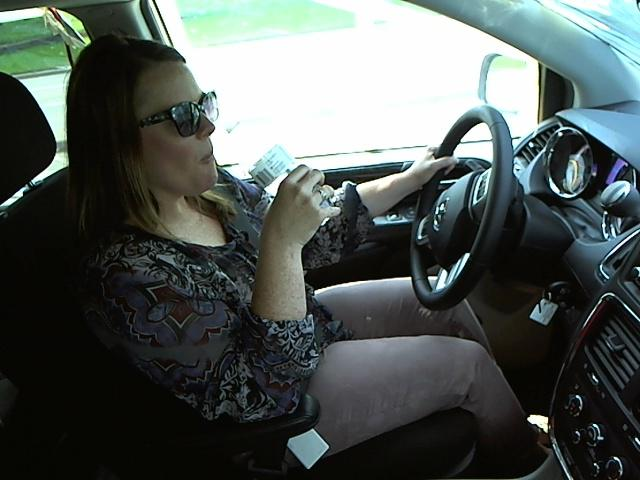

{'pred_list': [0.0017, 0.1099, 0.032, 0.0008, 0.001, 0.009, 0.6055, 0.006, 0.2211, 0.0129], 'pred_class': 'drinking', 'confidence': 0.6055}


In [145]:

display(PIL.Image.open(BytesIO(base64.b64decode(encoded_im))))
print(predictor.predict(input_data))

In [71]:
predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DescribeEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:820235860091:endpoint/pytorch-inference-2022-07-26-00-03-26-550".